In [1]:
import os
from io import StringIO
import re
import math
import random
import joblib
import numpy as np
import pandas as pd
from time import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import nrrd
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.ndimage import zoom
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.hub import load_state_dict_from_url
from torch.utils.data import WeightedRandomSampler, DataLoader
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import functional
import torchvision.models as models

C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Setting working directory
# Update this path to point to your local data directory
path = r"path/to/Data/Classification"
os.chdir(path)

In [3]:
# Read data file
mpath = os.path.join(path, r'LabelledData20230526.csv')
mdata = pd.read_csv(mpath)
mdata = mdata[mdata['Reject'].isna()]
mdata = mdata.iloc[1:,:].reset_index(drop=True)
mdata

,Batch,Type,CT Scan,Tooth,Voxel,Label,Reject
0,FIRST SCAN,MOLARS 1142AM,3 Pediatric 0.5,Tooth_002.nrrd,56840,maxillary molar,NaN
1,FIRST SCAN,MOLARS 1142AM,3 Pediatric 0.5,Tooth_004.nrrd,59584,mandibular molar,NaN
2,FIRST SCAN,MOLARS 1142AM,3 Pediatric 0.5,Tooth_008.nrrd,46953,mandibular molar,NaN
3,FIRST SCAN,MOLARS 1142AM,3 Pediatric 0.5,Tooth_009.nrrd,53406,mandibular molar,NaN
4,FIRST SCAN,MOLARS 1142AM,3 Pediatric 0.5,Tooth_010.nrrd,100595,maxillary molar,NaN
...,...,...,...,...,...,...,...
355,Batch 2,22ND NOV 2022,2 Spine 1.0,Tooth_132.nrrd,4368,maxillary molar,NaN
356,Batch 2,22ND NOV 2022,2 Spine 1.0,Tooth_134.nrrd,5184,maxillary molar,NaN
357,Batch 2,22ND NOV 2022,2 Spine 1.0,Tooth_135.nrrd,3640,maxillary molar,NaN
358,Batch 2,22ND NOV 2022,2 Spine 1.0,Tooth_137.nrrd,4576,maxillary molar,NaN


<Axes: xlabel='Teeth', ylabel='frequency'>

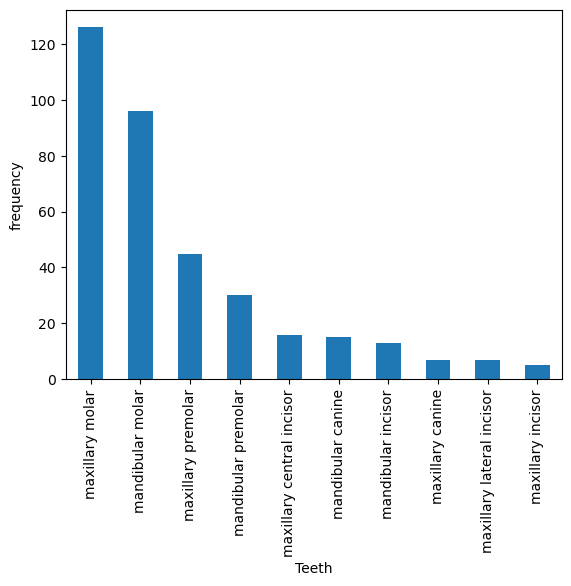

In [4]:
fig, ax = plt.subplots()

mdata['Label'].value_counts().plot(ax=ax, kind='bar', xlabel='Teeth', ylabel='frequency')

In [5]:
mdata['Label'].value_counts()

Label
maxillary molar              126
mandibular molar              96
maxillary premolar            45
mandibular premolar           30
maxillary central incisor     16
mandibular canine             15
mandibular incisor            13
maxillary canine               7
maxillary lateral incisor      7
maxillary incisor              5
Name: count, dtype: int64

In [6]:
n_classes = len(set(mdata['Label']))
n_classes

10

In [7]:
lab_dict = {'mandibular canine' : 0,
            'mandibular incisor' : 1,
            'mandibular molar' : 2,
            'mandibular premolar' : 3,
            'maxillary canine' : 4,
            'maxillary central incisor' : 5,
            'maxillary incisor' : 6,
            'maxillary lateral incisor' : 7,
            'maxillary molar' : 8,
            'maxillary premolar' : 9}

In [8]:
target_names = ['mandibular canine',
                'mandibular incisor',
                'mandibular molar',
                'mandibular premolar',
                'maxillary canine',
                'maxillary central incisor',
                'maxillary incisor',
                'maxillary lateral incisor',
                'maxillary molar',
                'maxillary premolar']

In [9]:
X_train, X_valid_test = train_test_split(mdata, stratify=mdata['Label'], test_size=0.51, random_state=42)
X_valid, X_test = train_test_split(X_valid_test, stratify=X_valid_test['Label'], test_size=0.5, random_state=42)
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [10]:
class TrainImageDataset(Dataset):
    def __init__(self, img_dir, mdata, lab_dict, transform=None, target_transform=None):
        self.mdata = mdata
        self.labels = self.mdata['Label']
        self.img_dir = img_dir
        self.lab_dict = lab_dict
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.mdata)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, 
                                self.mdata['Batch'][idx], 
                                self.mdata['Type'][idx], 
                                self.mdata['CT Scan'][idx], 
                                self.mdata['Tooth'][idx])
        
        image, _ = nrrd.read(img_path)
        image = image.astype(float)
        
        # Ensure iamge align in the same direction
        idz = np.argmax(image.shape)
        ind = [0,1,2]
        ind.remove(idz)
        new_ind = [idz]
        new_ind.extend(ind)
        image = np.transpose(image, new_ind)
        
        lab = self.labels[idx]
        label = torch.zeros(len(self.lab_dict))
        label[self.lab_dict[lab]] = 1
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [11]:
class Resize3D(object):
    def __init__(self, target_shape):
        self.target_shape = target_shape

    def __call__(self, image):

        tz, tx, ty = self.target_shape
        z, x, y = image.shape

        zf = tz / np.max([z, x, y])

        if z * zf > tz:
            zf = tz / z
        if x * zf > tx:
            zf = tx / x
        if y * zf > ty:
            zf = ty / y

        resized_image = zoom(image, zf)
        resized_image = torch.tensor(resized_image,dtype=torch.float)
        
        return resized_image
    

In [12]:
class Pad3D(object):
    def __init__(self, target_shape, value=0):
        self.target_shape = target_shape
        self.value = value
        
    def __call__(self, image):
        l, w, h = image.shape
        tx, ty, tz = self.target_shape

        if (h > tz) or (l > tx) or (w > ty):
            raise ValueError('Input image is larger than the target size.')

        mh = int(tz / 2)
        ml = int(tx / 2)
        mw = int(ty / 2)

        out = torch.zeros(self.target_shape,dtype=torch.float) + self.value

        out[(ml - l//2):(ml - l//2 + l), (mw - w//2):(mw - w//2 + w), (mh - h//2):(mh - h//2 + h)] = image
        
        return out

In [13]:
augmentation = transforms.Compose([
    Resize3D([128, 64, 64]),
    Pad3D([128, 91, 91]),
    transforms.RandomRotation([-90, 90])
])

In [14]:
preprocess = transforms.Compose([
    Resize3D([128, 64, 64]),
    Pad3D([128, 91, 91]),
])

In [15]:
count = X_train['Label'].value_counts()
freq = []
for key in lab_dict:
    freq.append(count.loc[key])

weights = torch.tensor(freq)
weights = 1/(weights)
weights = weights/torch.sum(weights)
print(freq)
print(weights)

[7, 6, 47, 15, 3, 8, 3, 3, 62, 22]
tensor([0.0902, 0.1052, 0.0134, 0.0421, 0.2104, 0.0789, 0.2104, 0.2104, 0.0102,
        0.0287])


In [16]:
train_set = TrainImageDataset(path, X_train, lab_dict, transform=augmentation, target_transform=None)
#sampler = WeightedRandomSampler(weights, num_samples=len(X_train))
#train_queue = DataLoader(train_set, batch_size=8, sampler=sampler, num_workers=0)
train_queue = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0)

valid_set = TrainImageDataset(path, X_valid, lab_dict, transform=preprocess, target_transform=None)
valid_queue = DataLoader(valid_set, batch_size=4, shuffle=None, num_workers=0)
test_set = TrainImageDataset(path, X_test, lab_dict, transform=preprocess, target_transform=None)
test_queue = DataLoader(test_set, batch_size=4, shuffle=None, num_workers=0)

Image 92


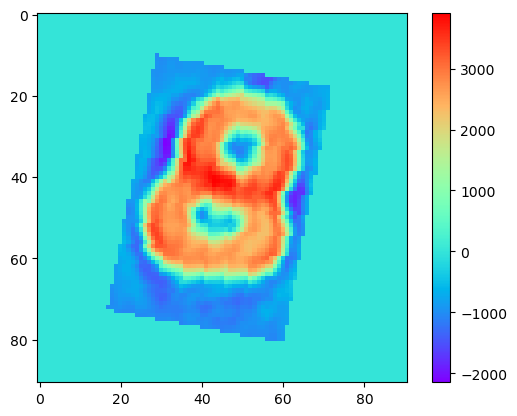

In [28]:
idx = random.randint(0, len(train_set)-1)
print("Image", idx)
plt.imshow(train_set[idx][0][train_set[idx][0].shape[0]//2, :, :], cmap = matplotlib.colormaps["rainbow"])
plt.colorbar()
plt.show()

# 2D Models

In [61]:
def validation(valid_queue):
    ## set model to evaluation mode
    model.eval()
    ## evaluation
    ep_loss = 0.0
    ep_acc = 0.0
    ep_macro = 0.0
    y_collection = []
    p_collection = []

    with torch.no_grad(): 
        start = time()
        for step, (img, y) in enumerate(valid_queue):
            img = (img - torch.mean(img)) / torch.std(img)
            x_img = img.to(device)
            y = y.to(device)
            # calculate output
            p = model(x_img)
            # calculate metrics
            loss = criterion(p, y)
            y_true = torch.argmax(y, dim = 1).cpu()
            y_pred = torch.argmax(p, dim = 1).cpu()
            y_collection.append(y_true)
            p_collection.append(y_pred)
            acc = f1_score(y_true, y_pred, average='micro')
            macro = f1_score(y_true, y_pred, average='macro')
            ep_loss += loss.item()
            ep_acc += acc
            ep_macro += macro
            if step % 1 == 0:
                step_time = (time() - start)/(step+1)
                print('\rValidation step: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Step time: %.4f s'
                        % (step, ep_loss/(step+1), ep_acc/(step+1), ep_macro/(step+1), step_time), end='')
    
    val_time = time() - start
    result = torch.cat(p_collection, dim=0)
    label = torch.cat(y_collection, dim=0)
    micro = f1_score(label, result, average='micro')
    macro = f1_score(label, result, average='macro')
    
    print('\nValidation loss: %.6f Micro-F1 %.6f Macro-F1 %.6f validation time: %.4f s'
            % (ep_loss/(step+1), micro, macro, val_time))
    
    return micro

In [62]:
def train(train_queue):
    ## set model to training mode
    model.train()
    # training
    ep_loss = 0.0
    ep_acc = 0.0
    ep_macro = 0.0
    y_collection = []
    p_collection = []
    
    for step, (img, y) in enumerate(train_queue):
        start = time()
        # batch normalisation
        img = (img - torch.mean(img)) / torch.std(img)
        x_img = img.to(device)
        y = y.to(device)
        # set gradient to zero        
        optimizer.zero_grad()
        # calculate output
        p = model(x_img)
        # calculate metrics
        loss = criterion(p, y)
        y_true = torch.argmax(y, dim = 1).cpu()
        y_pred = torch.argmax(p, dim = 1).cpu()
        y_collection.append(y_true)
        p_collection.append(y_pred)
        acc = f1_score(y_true, y_pred, average='micro')
        macro = f1_score(y_true, y_pred, average='macro')
        ep_loss += loss.item()
        ep_acc += acc
        ep_macro += macro
        # back-prop
        loss.backward()
        # update parameters
        optimizer.step()
        if step % 1 == 0:
            step_time = (time() - start)/(step+1)
            print('\rEpoch: %d Step: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Step time: %.4f s'
                  % (ep, step, ep_loss/(step+1), ep_acc/(step+1), ep_macro/(step+1), step_time), end='')

    result = torch.cat(p_collection, dim=0)
    label = torch.cat(y_collection, dim=0)
    micro = f1_score(label, result, average='micro')
    macro = f1_score(label, result, average='macro')
    
    return ep_loss/(step+1), micro, macro

# ResNet

In [63]:
# Modify the model architecture for 3D CT classification
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False)
        self.net = models.resnet34(num_classes)
        self.clf = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.net(x)
        x = self.clf(x)
        
        return x


In [64]:
epochs = 30
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

model = ResNet(n_classes).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

f1_record = 0

for ep in range(epochs):

    start = time()
    loss, micro, macro = train(train_queue)
    epoch_time = time() - start
    print('\nEpoch: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Epoch time: %.4f s'
          % (ep, loss, micro, macro, epoch_time))
    
    f1 = validation(valid_queue)
    
    if f1 > f1_record:
        torch.save(model.state_dict(), "ResNet.pth")
        ResNet_model = model
        f1_record = f1
        print("New record saved!")


Device: cuda


C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 Step: 43 Loss: 2.225978 Micro-F1: 0.329545 Macro-F1: 0.237753 Step time: 0.0010 s
Epoch: 0 Loss: 2.225978 Micro-F1: 0.329545 Macro-F1: 0.237753 Epoch time: 23.0187 s
Validation step: 22 Loss: 2.385190 Micro-F1: 0.445652 Macro-F1: 0.304331 Step time: 0.4399 s
Validation loss: 2.385190 Micro-F1 0.445652 Macro-F1 0.183247 validation time: 10.1190 s
New record saved!
Epoch: 1 Step: 43 Loss: 1.671716 Micro-F1: 0.482955 Macro-F1: 0.350108 Step time: 0.0012 s
Epoch: 1 Loss: 1.671716 Micro-F1: 0.482955 Macro-F1: 0.350108 Epoch time: 22.2127 s
Validation step: 22 Loss: 1.932972 Micro-F1: 0.402174 Macro-F1: 0.273913 Step time: 0.5086 s
Validation loss: 1.932972 Micro-F1 0.402174 Macro-F1 0.239127 validation time: 11.6999 s
Epoch: 2 Step: 43 Loss: 1.448759 Micro-F1: 0.500000 Macro-F1: 0.364917 Step time: 0.0011 s
Epoch: 2 Loss: 1.448759 Micro-F1: 0.500000 Macro-F1: 0.364917 Epoch time: 21.5131 s
Validation step: 22 Loss: 1.781464 Micro-F1: 0.521739 Macro-F1: 0.371411 Step time: 0.4561 s


Validation step: 22 Loss: 0.861333 Micro-F1: 0.750000 Macro-F1: 0.606556 Step time: 0.4833 s
Validation loss: 0.861333 Micro-F1 0.750000 Macro-F1 0.553889 validation time: 11.1164 s
Epoch: 23 Step: 43 Loss: 0.784425 Micro-F1: 0.732955 Macro-F1: 0.599639 Step time: 0.0009 s
Epoch: 23 Loss: 0.784425 Micro-F1: 0.732955 Macro-F1: 0.599639 Epoch time: 23.3779 s
Validation step: 22 Loss: 0.842612 Micro-F1: 0.771739 Macro-F1: 0.630435 Step time: 0.5254 s
Validation loss: 0.842612 Micro-F1 0.771739 Macro-F1 0.675023 validation time: 12.0858 s
Epoch: 24 Step: 43 Loss: 0.580644 Micro-F1: 0.806818 Macro-F1: 0.730177 Step time: 0.0010 s
Epoch: 24 Loss: 0.580644 Micro-F1: 0.806818 Macro-F1: 0.730177 Epoch time: 20.4777 s
Validation step: 22 Loss: 0.897451 Micro-F1: 0.739130 Macro-F1: 0.613527 Step time: 0.4671 s
Validation loss: 0.897451 Micro-F1 0.739130 Macro-F1 0.567189 validation time: 10.7463 s
Epoch: 25 Step: 43 Loss: 0.327567 Micro-F1: 0.869318 Macro-F1: 0.804942 Step time: 0.0010 s
Epoch: 2

In [65]:
# Test
model = ResNet_model
model.eval()

y_collection = []
p_collection = []
with torch.no_grad(): 
    start = time()
    for step, (img, y) in enumerate(test_queue):
        if torch.cuda.is_available():
            # batch normalisation
            img = (img - torch.mean(img)) / torch.std(img)
            x_img = img.to('cuda')
            y = y.to('cuda')

        # calculate output
        p = model(x_img)
        y_true = torch.argmax(y, dim = 1).cpu()
        y_pred = torch.argmax(p, dim = 1).cpu()
        y_collection.append(y_true)
        p_collection.append(y_pred)
        
        if step % 1 == 0:
            step_time = (time() - start)/(step+1)
            print('\rStep: %d Step time: %.4f s' % (step, step_time), end='')

result = torch.cat(p_collection, dim=0)
label = torch.cat(y_collection, dim=0)

print('\nTotal test time: %.4f s' % (time() - start), end='')

Step: 22 Step time: 0.4533 s
Total test time: 10.4271 s

In [66]:
f1_score(label, result, average='micro')

0.6847826086956522

In [67]:
accuracy_score(label, result)

0.6847826086956522

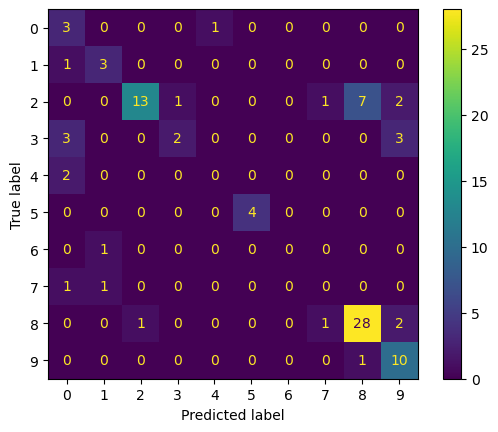

In [68]:
cm = confusion_matrix(label, result)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [69]:
lab_dict

{'mandibular canine': 0,
 'mandibular incisor': 1,
 'mandibular molar': 2,
 'mandibular premolar': 3,
 'maxillary canine': 4,
 'maxillary central incisor': 5,
 'maxillary incisor': 6,
 'maxillary lateral incisor': 7,
 'maxillary molar': 8,
 'maxillary premolar': 9}

In [70]:
X_train['Label'].value_counts()

Label
maxillary molar              62
mandibular molar             47
maxillary premolar           22
mandibular premolar          15
maxillary central incisor     8
mandibular canine             7
mandibular incisor            6
maxillary canine              3
maxillary incisor             3
maxillary lateral incisor     3
Name: count, dtype: int64

In [71]:
print(classification_report(label, result, target_names=target_names))

                           precision    recall  f1-score   support

        mandibular canine       0.30      0.75      0.43         4
       mandibular incisor       0.60      0.75      0.67         4
         mandibular molar       0.93      0.54      0.68        24
      mandibular premolar       0.67      0.25      0.36         8
         maxillary canine       0.00      0.00      0.00         2
maxillary central incisor       1.00      1.00      1.00         4
        maxillary incisor       0.00      0.00      0.00         1
maxillary lateral incisor       0.00      0.00      0.00         2
          maxillary molar       0.78      0.88      0.82        32
       maxillary premolar       0.59      0.91      0.71        11

                 accuracy                           0.68        92
                macro avg       0.49      0.51      0.47        92
             weighted avg       0.72      0.68      0.67        92



C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# VGG16

In [72]:
# Modify the model architecture for 3D CT classification
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.conv1 = nn.Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False)
        self.net = models.vgg16(num_classes)
        self.clf = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.net(x)
        x = self.clf(x)
        
        return x


In [73]:
epochs = 30
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

model = VGG16(n_classes).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

f1_record = 0

for ep in range(epochs):

    start = time()
    loss, micro, macro = train(train_queue)
    epoch_time = time() - start
    print('\nEpoch: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Epoch time: %.4f s'
          % (ep, loss, micro, macro, epoch_time))
    
    f1 = validation(valid_queue)
    
    if f1 > f1_record:
        torch.save(model.state_dict(), "VGG16.pth")
        VGG16_model = model
        f1_record = f1
        print("New record saved!")


C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda
Epoch: 0 Step: 43 Loss: 2.137480 Micro-F1: 0.295455 Macro-F1: 0.171907 Step time: 0.0008 s
Epoch: 0 Loss: 2.137480 Micro-F1: 0.295455 Macro-F1: 0.171907 Epoch time: 20.1046 s
Validation step: 22 Loss: 1.714525 Micro-F1: 0.315217 Macro-F1: 0.185939 Step time: 0.4582 s
Validation loss: 1.714525 Micro-F1 0.315217 Macro-F1 0.069559 validation time: 10.5407 s
New record saved!
Epoch: 1 Step: 43 Loss: 1.662937 Micro-F1: 0.352273 Macro-F1: 0.220473 Step time: 0.0009 s
Epoch: 1 Loss: 1.662937 Micro-F1: 0.352273 Macro-F1: 0.220473 Epoch time: 20.1440 s
Validation step: 22 Loss: 1.459448 Micro-F1: 0.402174 Macro-F1: 0.294324 Step time: 0.4661 s
Validation loss: 1.459448 Micro-F1 0.402174 Macro-F1 0.160897 validation time: 10.7223 s
New record saved!
Epoch: 2 Step: 43 Loss: 1.566166 Micro-F1: 0.409091 Macro-F1: 0.259821 Step time: 0.0008 s
Epoch: 2 Loss: 1.566166 Micro-F1: 0.409091 Macro-F1: 0.259821 Epoch time: 19.9204 s
Validation step: 22 Loss: 1.422601 Micro-F1: 0.467391 Macro-F1

Validation step: 22 Loss: 1.007205 Micro-F1: 0.728261 Macro-F1: 0.583368 Step time: 0.4279 s
Validation loss: 1.007205 Micro-F1 0.728261 Macro-F1 0.479992 validation time: 9.8436 s
Epoch: 23 Step: 43 Loss: 0.827358 Micro-F1: 0.710227 Macro-F1: 0.630240 Step time: 0.0007 s
Epoch: 23 Loss: 0.827358 Micro-F1: 0.710227 Macro-F1: 0.630240 Epoch time: 18.8575 s
Validation step: 22 Loss: 0.640195 Micro-F1: 0.771739 Macro-F1: 0.635628 Step time: 0.4421 s
Validation loss: 0.640195 Micro-F1 0.771739 Macro-F1 0.506027 validation time: 10.1697 s
New record saved!
Epoch: 24 Step: 43 Loss: 0.854638 Micro-F1: 0.710227 Macro-F1: 0.595572 Step time: 0.0009 s
Epoch: 24 Loss: 0.854638 Micro-F1: 0.710227 Macro-F1: 0.595572 Epoch time: 18.8773 s
Validation step: 22 Loss: 0.922201 Micro-F1: 0.750000 Macro-F1: 0.631280 Step time: 0.4355 s
Validation loss: 0.922201 Micro-F1 0.750000 Macro-F1 0.515963 validation time: 10.0193 s
Epoch: 25 Step: 43 Loss: 0.793417 Micro-F1: 0.715909 Macro-F1: 0.599134 Step time: 

In [74]:
# Test
model = VGG16_model
model.eval()

y_collection = []
p_collection = []
with torch.no_grad(): 
    start = time()
    for step, (img, y) in enumerate(test_queue):
        if torch.cuda.is_available():
            # batch normalisation
            img = (img - torch.mean(img)) / torch.std(img)
            x_img = img.to('cuda')
            y = y.to('cuda')

        # calculate output
        p = model(x_img)
        y_true = torch.argmax(y, dim = 1).cpu()
        y_pred = torch.argmax(p, dim = 1).cpu()
        y_collection.append(y_true)
        p_collection.append(y_pred)
        
        if step % 1 == 0:
            step_time = (time() - start)/(step+1)
            print('\rStep: %d Step time: %.4f s' % (step, step_time), end='')

result = torch.cat(p_collection, dim=0)
label = torch.cat(y_collection, dim=0)

print('\nTotal test time: %.4f s' % (time() - start), end='')

Step: 22 Step time: 0.4422 s
Total test time: 10.1720 s

In [75]:
f1_score(label, result, average='micro')

0.6847826086956522

In [76]:
accuracy_score(label, result)

0.6847826086956522

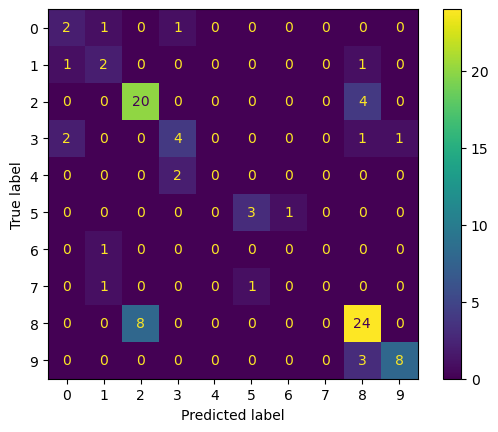

In [77]:
cm = confusion_matrix(label, result)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [78]:
lab_dict

{'mandibular canine': 0,
 'mandibular incisor': 1,
 'mandibular molar': 2,
 'mandibular premolar': 3,
 'maxillary canine': 4,
 'maxillary central incisor': 5,
 'maxillary incisor': 6,
 'maxillary lateral incisor': 7,
 'maxillary molar': 8,
 'maxillary premolar': 9}

In [79]:
print(classification_report(label, result, target_names=target_names))

                           precision    recall  f1-score   support

        mandibular canine       0.40      0.50      0.44         4
       mandibular incisor       0.40      0.50      0.44         4
         mandibular molar       0.71      0.83      0.77        24
      mandibular premolar       0.57      0.50      0.53         8
         maxillary canine       0.00      0.00      0.00         2
maxillary central incisor       0.75      0.75      0.75         4
        maxillary incisor       0.00      0.00      0.00         1
maxillary lateral incisor       0.00      0.00      0.00         2
          maxillary molar       0.73      0.75      0.74        32
       maxillary premolar       0.89      0.73      0.80        11

                 accuracy                           0.68        92
                macro avg       0.45      0.46      0.45        92
             weighted avg       0.66      0.68      0.67        92



C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# AlexNet

In [80]:
# Modify the model architecture for 3D CT classification
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False)
        self.net = models.alexnet(num_classes)
        self.clf = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.net(x)
        x = self.clf(x)
        
        return x


In [81]:
epochs = 30
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

model = AlexNet(n_classes).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

f1_record = 0

for ep in range(epochs):

    start = time()
    loss, micro, macro = train(train_queue)
    epoch_time = time() - start
    print('\nEpoch: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Epoch time: %.4f s'
          % (ep, loss, micro, macro, epoch_time))
    
    f1 = validation(valid_queue)
    
    if f1 > f1_record:
        torch.save(model.state_dict(), "AlexNet.pth")
        AlexNet_model = model
        f1_record = f1
        print("New record saved!")


C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda
Epoch: 0 Step: 43 Loss: 2.241443 Micro-F1: 0.323864 Macro-F1: 0.220094 Step time: 0.0004 s
Epoch: 0 Loss: 2.241443 Micro-F1: 0.323864 Macro-F1: 0.220094 Epoch time: 18.0809 s
Validation step: 22 Loss: 1.449465 Micro-F1: 0.532609 Macro-F1: 0.387077 Step time: 0.4025 s
Validation loss: 1.449465 Micro-F1 0.532609 Macro-F1 0.213445 validation time: 9.2585 s
New record saved!
Epoch: 1 Step: 43 Loss: 1.448885 Micro-F1: 0.482955 Macro-F1: 0.336147 Step time: 0.0004 s
Epoch: 1 Loss: 1.448885 Micro-F1: 0.482955 Macro-F1: 0.336147 Epoch time: 18.3571 s
Validation step: 22 Loss: 1.606364 Micro-F1: 0.467391 Macro-F1: 0.318754 Step time: 0.4089 s
Validation loss: 1.606364 Micro-F1 0.467391 Macro-F1 0.166371 validation time: 9.4057 s
Epoch: 2 Step: 43 Loss: 1.355540 Micro-F1: 0.494318 Macro-F1: 0.370770 Step time: 0.0004 s
Epoch: 2 Loss: 1.355540 Micro-F1: 0.494318 Macro-F1: 0.370770 Epoch time: 17.9744 s
Validation step: 22 Loss: 1.045740 Micro-F1: 0.652174 Macro-F1: 0.497705 Step time

In [82]:
# Test
model = AlexNet_model
model.eval()

y_collection = []
p_collection = []
with torch.no_grad(): 
    start = time()
    for step, (img, y) in enumerate(test_queue):
        if torch.cuda.is_available():
            # batch normalisation
            img = (img - torch.mean(img)) / torch.std(img)
            x_img = img.to('cuda')
            y = y.to('cuda')

        # calculate output
        p = model(x_img)
        y_true = torch.argmax(y, dim = 1).cpu()
        y_pred = torch.argmax(p, dim = 1).cpu()
        y_collection.append(y_true)
        p_collection.append(y_pred)
        
        if step % 1 == 0:
            step_time = (time() - start)/(step+1)
            print('\rStep: %d Step time: %.4f s' % (step, step_time), end='')

result = torch.cat(p_collection, dim=0)
label = torch.cat(y_collection, dim=0)

print('\nTotal test time: %.4f s' % (time() - start), end='')

Step: 22 Step time: 0.4079 s
Total test time: 9.3836 s

In [83]:
f1_score(label, result, average='micro')

0.6739130434782609

In [84]:
accuracy_score(label, result)

0.6739130434782609

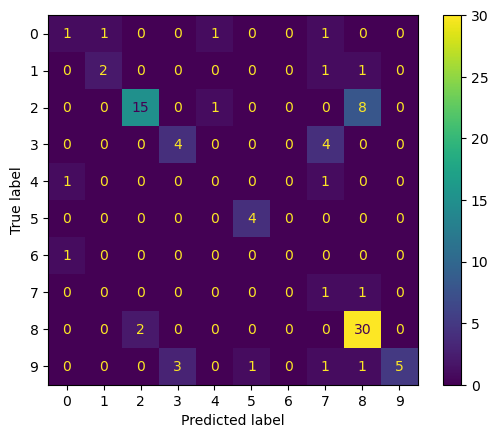

In [85]:
cm = confusion_matrix(label, result)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [86]:
lab_dict

{'mandibular canine': 0,
 'mandibular incisor': 1,
 'mandibular molar': 2,
 'mandibular premolar': 3,
 'maxillary canine': 4,
 'maxillary central incisor': 5,
 'maxillary incisor': 6,
 'maxillary lateral incisor': 7,
 'maxillary molar': 8,
 'maxillary premolar': 9}

In [87]:
print(classification_report(label, result, target_names=target_names))

                           precision    recall  f1-score   support

        mandibular canine       0.33      0.25      0.29         4
       mandibular incisor       0.67      0.50      0.57         4
         mandibular molar       0.88      0.62      0.73        24
      mandibular premolar       0.57      0.50      0.53         8
         maxillary canine       0.00      0.00      0.00         2
maxillary central incisor       0.80      1.00      0.89         4
        maxillary incisor       0.00      0.00      0.00         1
maxillary lateral incisor       0.11      0.50      0.18         2
          maxillary molar       0.73      0.94      0.82        32
       maxillary premolar       1.00      0.45      0.62        11

                 accuracy                           0.67        92
                macro avg       0.51      0.48      0.46        92
             weighted avg       0.73      0.67      0.68        92



C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 3D Models

In [19]:
def train3D(train_queue):
    ## set model to training mode
    model.train()
    # training
    ep_loss = 0.0
    ep_acc = 0.0
    ep_macro = 0.0
    y_collection = []
    p_collection = []
    
    for step, (img, y) in enumerate(train_queue):
        start = time()
        # batch normalisation
        img = (img - torch.mean(img)) / torch.std(img)
        x_img = img[:, None, :, :, :].to(device)
        y = y.to(device)
        # set gradient to zero        
        optimizer.zero_grad()
        # calculate output
        p = model(x_img)
        # calculate metrics
        loss = criterion(p, y)
        y_true = torch.argmax(y, dim = 1).cpu()
        y_pred = torch.argmax(p, dim = 1).cpu()
        y_collection.append(y_true)
        p_collection.append(y_pred)
        acc = f1_score(y_true, y_pred, average='micro')
        macro = f1_score(y_true, y_pred, average='macro')
        ep_loss += loss.item()
        ep_acc += acc
        ep_macro += macro
        # back-prop
        loss.backward()
        # update parameters
        optimizer.step()
        if step % 1 == 0:
            step_time = (time() - start)/(step+1)
            print('\rEpoch: %d Step: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Step time: %.4f s'
                  % (ep, step, ep_loss/(step+1), ep_acc/(step+1), ep_macro/(step+1), step_time), end='')
    
   
    result = torch.cat(p_collection, dim=0)
    label = torch.cat(y_collection, dim=0)
    micro = f1_score(label, result, average='micro')
    macro = f1_score(label, result, average='macro')
    
    return ep_loss/(step+1), micro, macro

In [20]:
def validation3D(valid_queue):
    ## set model to evaluation mode
    model.eval()
    ## evaluation
    ep_loss = 0.0
    ep_acc = 0.0
    ep_macro = 0.0
    y_collection = []
    p_collection = []


    with torch.no_grad(): 
        start = time()
        for step, (img, y) in enumerate(valid_queue):
            # batch normalisation
            img = (img - torch.mean(img)) / torch.std(img)
            x_img = img[:, None, :, :, :].to(device)
            y = y.to(device)
            # calculate output
            p = model(x_img)
            # calculate metrics
            loss = criterion(p, y)
            y_true = torch.argmax(y, dim = 1).cpu()
            y_pred = torch.argmax(p, dim = 1).cpu()
            y_collection.append(y_true)
            p_collection.append(y_pred)
            
            acc = f1_score(y_true, y_pred, average='micro')
            macro = f1_score(y_true, y_pred, average='macro')
            ep_loss += loss.item()
            ep_acc += acc
            ep_macro += macro
            if step % 1 == 0:
                step_time = (time() - start)/(step+1)
                print('\rValidation step: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Step time: %.4f s'
                        % (step, ep_loss/(step+1), ep_acc/(step+1), ep_macro/(step+1), step_time), end='')
    
    val_time = time() - start
    result = torch.cat(p_collection, dim=0)
    label = torch.cat(y_collection, dim=0)
    micro = f1_score(label, result, average='micro')
    macro = f1_score(label, result, average='macro')
    
    print('\nValidation loss: %.6f Micro-F1 %.6f Macro-F1 %.6f validation time: %.4f s'
            % (ep_loss/(step+1), micro, macro, val_time))
    
    return micro

# AlexNet3D

In [21]:
class AlexNet3D(nn.Module):

    def __init__(self, num_classes=1000, stem_stride=4):
        # invoke super class initialisation method
        super(AlexNet3D, self).__init__()
        
        # define the CNN:
        # 1. define feature extraction layers
        self.features = nn.Sequential(
            # conv-relu-pooling
            nn.Conv3d(1, 64, kernel_size=11, stride=stem_stride, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
            # conv-relu-pooling
            nn.Conv3d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
            # conv-relu-conv-relu-conv-relu-pooling
            nn.Conv3d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
        )
        # 2. define average pooling layer
        self.avgpool = nn.AdaptiveAvgPool3d((6, 6, 6))
        # 3. define fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),                   # use dropout
            nn.Linear(256 * 6 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),                   # use dropout
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    # define forward-propagation
    def forward(self, x):
        # feature extraction
        x = self.features(x)
        # adaptive pooling
        x = self.avgpool(x)
        # flat the feature map
        x = torch.flatten(x, 1)
        # classification
        x = self.classifier(x)
        return x

    # back-propagation is handled by PyTorch

In [21]:
epochs = 30
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

model = AlexNet3D(n_classes).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

f1_record = 0

for ep in range(epochs):

    start = time()
    loss, micro, macro = train3D(train_queue)
    epoch_time = time() - start
    print('\nEpoch: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Epoch time: %.4f s'
          % (ep, loss, micro, macro, epoch_time))
    
    f1 = validation3D(valid_queue)
    
    if f1 > f1_record:
        torch.save(model.state_dict(), "AlexNet3D.pth")
        AlexNet3D_model = model
        f1_record = f1
        print("New record saved!")


Device: cuda
Epoch: 0 Step: 43 Loss: 1.863363 Micro-F1: 0.329545 Macro-F1: 0.173647 Step time: 0.0006 s
Epoch: 0 Loss: 1.863363 Micro-F1: 0.329545 Macro-F1: 0.173647 Epoch time: 23.9893 s
Validation step: 22 Loss: 1.642070 Micro-F1: 0.347826 Macro-F1: 0.172326 Step time: 0.4524 s
Validation loss: 1.642070 Micro-F1 0.347826 Macro-F1 0.051613 validation time: 10.4072 s
New record saved!
Epoch: 1 Step: 43 Loss: 1.613239 Micro-F1: 0.352273 Macro-F1: 0.221185 Step time: 0.0007 s
Epoch: 1 Loss: 1.613239 Micro-F1: 0.352273 Macro-F1: 0.221185 Epoch time: 20.1451 s
Validation step: 22 Loss: 1.628591 Micro-F1: 0.369565 Macro-F1: 0.235818 Step time: 0.4809 s
Validation loss: 1.628591 Micro-F1 0.369565 Macro-F1 0.088077 validation time: 11.0612 s
New record saved!
Epoch: 2 Step: 43 Loss: 1.636838 Micro-F1: 0.261364 Macro-F1: 0.156394 Step time: 0.0006 s
Epoch: 2 Loss: 1.636838 Micro-F1: 0.261364 Macro-F1: 0.156394 Epoch time: 19.8074 s
Validation step: 22 Loss: 1.770423 Micro-F1: 0.402174 Macro-F1

Validation step: 22 Loss: 1.178048 Micro-F1: 0.521739 Macro-F1: 0.399034 Step time: 0.4608 s
Validation loss: 1.178048 Micro-F1 0.521739 Macro-F1 0.293686 validation time: 10.5993 s
Epoch: 23 Step: 43 Loss: 0.808074 Micro-F1: 0.710227 Macro-F1: 0.570536 Step time: 0.0007 s
Epoch: 23 Loss: 0.808074 Micro-F1: 0.710227 Macro-F1: 0.570536 Epoch time: 19.2968 s
Validation step: 22 Loss: 0.884628 Micro-F1: 0.750000 Macro-F1: 0.610386 Step time: 0.4630 s
Validation loss: 0.884628 Micro-F1 0.750000 Macro-F1 0.391691 validation time: 10.6502 s
Epoch: 24 Step: 43 Loss: 0.968940 Micro-F1: 0.607955 Macro-F1: 0.452895 Step time: 0.0006 s
Epoch: 24 Loss: 0.968940 Micro-F1: 0.607955 Macro-F1: 0.452895 Epoch time: 19.6028 s
Validation step: 22 Loss: 0.742524 Micro-F1: 0.728261 Macro-F1: 0.584058 Step time: 0.4601 s
Validation loss: 0.742524 Micro-F1 0.728261 Macro-F1 0.366631 validation time: 10.5847 s
Epoch: 25 Step: 43 Loss: 0.790947 Micro-F1: 0.659091 Macro-F1: 0.521311 Step time: 0.0006 s
Epoch: 2

In [22]:
# Test
model = AlexNet3D_model
model.eval()

y_collection = []
p_collection = []
with torch.no_grad(): 
    start = time()
    for step, (img, y) in enumerate(test_queue):
        if torch.cuda.is_available():
            # batch normalisation
            img = (img - torch.mean(img)) / torch.std(img)
            x_img = img[:, None, :, :, :].to('cuda')
            y = y.to('cuda')

        # calculate output
        p = model(x_img)
        y_true = torch.argmax(y, dim = 1).cpu()
        y_pred = torch.argmax(p, dim = 1).cpu()
        y_collection.append(y_true)
        p_collection.append(y_pred)
        
        if step % 1 == 0:
            step_time = (time() - start)/(step+1)
            print('\rStep: %d Step time: %.4f s' % (step, step_time), end='')

result = torch.cat(p_collection, dim=0)
label = torch.cat(y_collection, dim=0)

print('\nTotal test time: %.4f s' % (time() - start), end='')

Step: 22 Step time: 0.4865 s
Total test time: 11.1913 s

In [23]:
f1_score(label, result, average='micro')

0.6195652173913043

In [24]:
accuracy_score(label, result)

0.6195652173913043

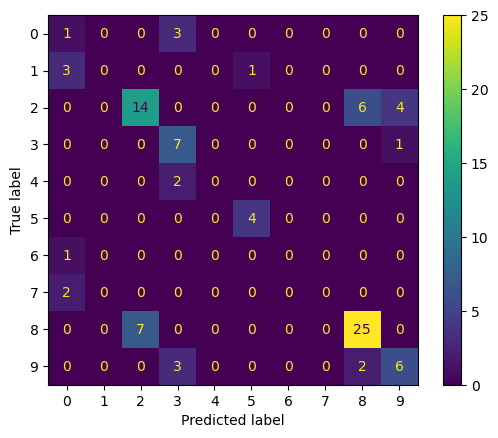

In [25]:
cm = confusion_matrix(label, result)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [26]:
lab_dict

{'mandibular canine': 0,
 'mandibular incisor': 1,
 'mandibular molar': 2,
 'mandibular premolar': 3,
 'maxillary canine': 4,
 'maxillary central incisor': 5,
 'maxillary incisor': 6,
 'maxillary lateral incisor': 7,
 'maxillary molar': 8,
 'maxillary premolar': 9}

In [27]:
print(classification_report(label, result, target_names=target_names))

                           precision    recall  f1-score   support

        mandibular canine       0.14      0.25      0.18         4
       mandibular incisor       0.00      0.00      0.00         4
         mandibular molar       0.67      0.58      0.62        24
      mandibular premolar       0.47      0.88      0.61         8
         maxillary canine       0.00      0.00      0.00         2
maxillary central incisor       0.80      1.00      0.89         4
        maxillary incisor       0.00      0.00      0.00         1
maxillary lateral incisor       0.00      0.00      0.00         2
          maxillary molar       0.76      0.78      0.77        32
       maxillary premolar       0.55      0.55      0.55        11

                 accuracy                           0.62        92
                macro avg       0.34      0.40      0.36        92
             weighted avg       0.58      0.62      0.59        92



C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
class AlexNet3D2(nn.Module):

    def __init__(self, num_classes=1000, stem_stride=4):
        # invoke super class initialisation method
        super(AlexNet3D2, self).__init__()
        
        # define the CNN:
        # 1. define feature extraction layers
        self.features = nn.Sequential(
            # conv-relu-pooling
            nn.Conv3d(1, 64, kernel_size=11, stride=stem_stride, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
            # conv-relu-pooling
            nn.Conv3d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
            # conv-relu-conv-relu-conv-relu-pooling
            nn.Conv3d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
        )
        # 2. define average pooling layer
        self.avgpool = nn.AdaptiveAvgPool3d((6, 6, 6))
        self.avgpool2 = nn.AdaptiveAvgPool3d((3, 3, 3))
        # 3. define fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),                   # use dropout
            nn.Linear(256 * 6 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),                   # use dropout
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.classifier2 = nn.Sequential(
            nn.Dropout(),                   # use dropout
            nn.Linear(256 * 3 * 3 * 3, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),                   # use dropout
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    # define forward-propagation
    def forward(self, x):
        # feature extraction
        x = self.features(x)
        # adaptive pooling
        x = self.avgpool2(x)
        # flat the feature map
        x = torch.flatten(x, 1)
        # classification
        x = self.classifier2(x)
        return x

    # back-propagation is handled by PyTorch

In [37]:
epochs = 30
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

model = AlexNet3D2(n_classes).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

f1_record = 0

for ep in range(epochs):

    start = time()
    loss, micro, macro = train3D(train_queue)
    epoch_time = time() - start
    print('\nEpoch: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Epoch time: %.4f s'
          % (ep, loss, micro, macro, epoch_time))
    
    f1 = validation3D(valid_queue)
    
    if f1 > f1_record:
        torch.save(model.state_dict(), "AlexNet3D2.pth")
        AlexNet3D2_model = model
        f1_record = f1
        print("New record saved!")


Device: cuda
Epoch: 0 Step: 43 Loss: 2.021946 Micro-F1: 0.255682 Macro-F1: 0.151109 Step time: 0.0011 s
Epoch: 0 Loss: 2.021946 Micro-F1: 0.255682 Macro-F1: 0.151109 Epoch time: 17.9289 s
Validation step: 22 Loss: 1.811126 Micro-F1: 0.402174 Macro-F1: 0.265286 Step time: 0.4155 s
Validation loss: 1.811126 Micro-F1 0.402174 Macro-F1 0.098337 validation time: 9.5578 s
New record saved!
Epoch: 1 Step: 43 Loss: 1.825842 Micro-F1: 0.346591 Macro-F1: 0.192821 Step time: 0.0006 s
Epoch: 1 Loss: 1.825842 Micro-F1: 0.346591 Macro-F1: 0.192821 Epoch time: 17.7202 s
Validation step: 22 Loss: 1.707374 Micro-F1: 0.434783 Macro-F1: 0.281522 Step time: 0.4218 s
Validation loss: 1.707374 Micro-F1 0.434783 Macro-F1 0.106471 validation time: 9.7035 s
New record saved!
Epoch: 2 Step: 43 Loss: 1.596433 Micro-F1: 0.369318 Macro-F1: 0.228301 Step time: 0.0006 s
Epoch: 2 Loss: 1.596433 Micro-F1: 0.369318 Macro-F1: 0.228301 Epoch time: 18.1402 s
Validation step: 22 Loss: 1.674204 Micro-F1: 0.347826 Macro-F1: 

In [38]:
# Test
model = AlexNet3D2_model
model.eval()

y_collection = []
p_collection = []
with torch.no_grad(): 
    start = time()
    for step, (img, y) in enumerate(test_queue):
        if torch.cuda.is_available():
            # batch normalisation
            img = (img - torch.mean(img)) / torch.std(img)
            x_img = img[:, None, :, :, :].to('cuda')
            y = y.to('cuda')

        # calculate output
        p = model(x_img)
        y_true = torch.argmax(y, dim = 1).cpu()
        y_pred = torch.argmax(p, dim = 1).cpu()
        y_collection.append(y_true)
        p_collection.append(y_pred)
        
        if step % 1 == 0:
            step_time = (time() - start)/(step+1)
            print('\rStep: %d Step time: %.4f s' % (step, step_time), end='')

result = torch.cat(p_collection, dim=0)
label = torch.cat(y_collection, dim=0)

print('\nTotal test time: %.4f s' % (time() - start), end='')

Step: 22 Step time: 0.4414 s
Total test time: 10.1541 s

In [39]:
f1_score(label, result, average='micro')

0.6847826086956522

In [40]:
accuracy_score(label, result)

0.6847826086956522

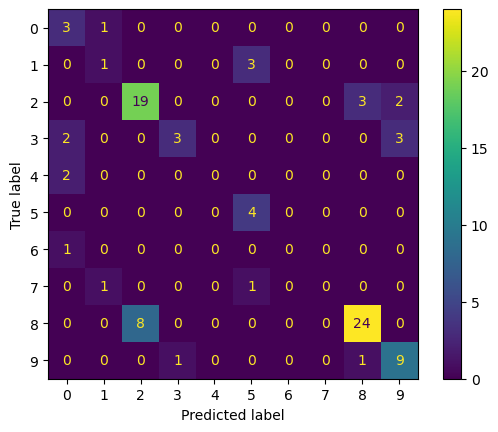

In [41]:
cm = confusion_matrix(label, result)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [42]:
lab_dict

{'mandibular canine': 0,
 'mandibular incisor': 1,
 'mandibular molar': 2,
 'mandibular premolar': 3,
 'maxillary canine': 4,
 'maxillary central incisor': 5,
 'maxillary incisor': 6,
 'maxillary lateral incisor': 7,
 'maxillary molar': 8,
 'maxillary premolar': 9}

In [43]:
print(classification_report(label, result, target_names=target_names))

                           precision    recall  f1-score   support

        mandibular canine       0.38      0.75      0.50         4
       mandibular incisor       0.33      0.25      0.29         4
         mandibular molar       0.70      0.79      0.75        24
      mandibular premolar       0.75      0.38      0.50         8
         maxillary canine       0.00      0.00      0.00         2
maxillary central incisor       0.50      1.00      0.67         4
        maxillary incisor       0.00      0.00      0.00         1
maxillary lateral incisor       0.00      0.00      0.00         2
          maxillary molar       0.86      0.75      0.80        32
       maxillary premolar       0.64      0.82      0.72        11

                 accuracy                           0.68        92
                macro avg       0.42      0.47      0.42        92
             weighted avg       0.68      0.68      0.67        92



C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ResNet3D

In [31]:
# Modify the model architecture for 3D CT classification
class ResNet3D(nn.Module):
    def __init__(self, num_classes):
        super(ResNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 3, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=(0, 0, 0), bias=False)
        self.net = models.video.r3d_18(num_classes)
        self.clf = nn.Linear(400, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.net(x)
        x = self.clf(x)
        
        return x


In [29]:
epochs = 30
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

model = ResNet3D(n_classes).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

f1_record = 0

for ep in range(epochs):

    start = time()
    loss, micro, macro = train3D(train_queue)
    epoch_time = time() - start
    print('\nEpoch: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Epoch time: %.4f s'
          % (ep, loss, micro, macro, epoch_time))
    
    f1 = validation3D(valid_queue)
    
    if f1 > f1_record:
        torch.save(model.state_dict(), "ResNet3D.pth")
        ResNet3D_model = model
        f1_record = f1
        print("New record saved!")


C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda
Epoch: 0 Step: 43 Loss: 1.841211 Micro-F1: 0.380682 Macro-F1: 0.262121 Step time: 0.0198 s
Epoch: 0 Loss: 1.841211 Micro-F1: 0.380682 Macro-F1: 0.262121 Epoch time: 62.3103 s
Validation step: 22 Loss: 1.486971 Micro-F1: 0.543478 Macro-F1: 0.401242 Step time: 0.8354 s
Validation loss: 1.486971 Micro-F1 0.543478 Macro-F1 0.264872 validation time: 19.2148 s
New record saved!
Epoch: 1 Step: 43 Loss: 1.322397 Micro-F1: 0.545455 Macro-F1: 0.408396 Step time: 0.0227 s
Epoch: 1 Loss: 1.322397 Micro-F1: 0.545455 Macro-F1: 0.408396 Epoch time: 63.2077 s
Validation step: 22 Loss: 0.993106 Micro-F1: 0.608696 Macro-F1: 0.477088 Step time: 0.8202 s
Validation loss: 0.993106 Micro-F1 0.608696 Macro-F1 0.352013 validation time: 18.8664 s
New record saved!
Epoch: 2 Step: 43 Loss: 1.035322 Micro-F1: 0.602273 Macro-F1: 0.481629 Step time: 0.0235 s
Epoch: 2 Loss: 1.035322 Micro-F1: 0.602273 Macro-F1: 0.481629 Epoch time: 63.2139 s
Validation step: 22 Loss: 1.172819 Micro-F1: 0.663043 Macro-F1

In [30]:
# Test
model = ResNet3D_model
model.eval()

y_collection = []
p_collection = []
with torch.no_grad(): 
    start = time()
    for step, (img, y) in enumerate(test_queue):
        if torch.cuda.is_available():
            # batch normalisation
            img = (img - torch.mean(img)) / torch.std(img)
            x_img = img[:, None, :, :, :].to('cuda')
            y = y.to('cuda')

        # calculate output
        p = model(x_img)
        y_true = torch.argmax(y, dim = 1).cpu()
        y_pred = torch.argmax(p, dim = 1).cpu()
        y_collection.append(y_true)
        p_collection.append(y_pred)
        
        if step % 1 == 0:
            step_time = (time() - start)/(step+1)
            print('\rStep: %d Step time: %.4f s' % (step, step_time), end='')

result = torch.cat(p_collection, dim=0)
label = torch.cat(y_collection, dim=0)

print('\nTotal test time: %.4f s' % (time() - start), end='')

Step: 22 Step time: 0.7741 s
Total test time: 17.8053 s

In [31]:
f1_score(label, result, average='micro')

0.7282608695652174

In [32]:
accuracy_score(label, result)

0.7282608695652174

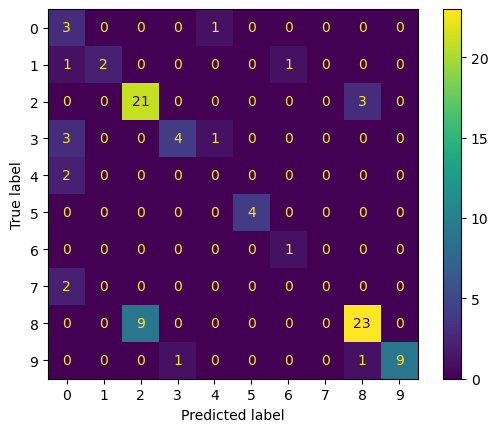

In [33]:
cm = confusion_matrix(label, result)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [34]:
lab_dict

{'mandibular canine': 0,
 'mandibular incisor': 1,
 'mandibular molar': 2,
 'mandibular premolar': 3,
 'maxillary canine': 4,
 'maxillary central incisor': 5,
 'maxillary incisor': 6,
 'maxillary lateral incisor': 7,
 'maxillary molar': 8,
 'maxillary premolar': 9}

In [35]:
print(classification_report(label, result, target_names=target_names))

                           precision    recall  f1-score   support

        mandibular canine       0.27      0.75      0.40         4
       mandibular incisor       1.00      0.50      0.67         4
         mandibular molar       0.70      0.88      0.78        24
      mandibular premolar       0.80      0.50      0.62         8
         maxillary canine       0.00      0.00      0.00         2
maxillary central incisor       1.00      1.00      1.00         4
        maxillary incisor       0.50      1.00      0.67         1
maxillary lateral incisor       0.00      0.00      0.00         2
          maxillary molar       0.85      0.72      0.78        32
       maxillary premolar       1.00      0.82      0.90        11

                 accuracy                           0.73        92
                macro avg       0.61      0.62      0.58        92
             weighted avg       0.77      0.73      0.73        92



C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
ResNet_model = ResNet(n_classes).to(device)
ResNet_model.load_state_dict(torch.load('ResNet.pth'))
VGG16_model = VGG16(n_classes).to(device)
VGG16_model.load_state_dict(torch.load('VGG16.pth'))
AlexNet_model = AlexNet(n_classes).to(device)
AlexNet_model.load_state_dict(torch.load('AlexNet.pth'))

C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG

<All keys matched successfully>

In [68]:
ep_acc = 0.0
ep_macro = 0.0
y_collection = []
vs_collection = []
vh_collection = []

with torch.no_grad(): 
    start = time()
    for step, (img, y) in enumerate(test_queue):
        if torch.cuda.is_available():
            # batch normalisation
            img = (img - torch.mean(img)) / torch.std(img)
            x_img = img.to('cuda')
            y = y.to('cuda')
        
        # calculate output
        ResNet_model.eval()
        p1 = ResNet_model(x_img)
        p1h = torch.argmax(p1, dim=1)
        
        VGG16_model.eval()
        p2 = VGG16_model(x_img)
        p2h = torch.argmax(p2, dim=1)
        
        AlexNet_model.eval()
        p3 = AlexNet_model(x_img)
        p3h = torch.argmax(p3, dim=1)
        AlexNet3D_model.eval()
        p4 = AlexNet3D_model(x_img[:, None, :, :, :])
        p4h = torch.argmax(p4, dim=1)
        
        ResNet3D_model.eval()
        p5 = ResNet3D_model(x_img[:, None, :, :, :])
        p5h = torch.argmax(p5, dim=1)
                
        #Voting
        vs = torch.argmax((p1 + p2 + p3 + p4 + p5)/5, dim=1)
        vh = torch.stack([p1h, p2h, p3h, p4h, p5h])
        vh = torch.mode(vh, dim=0).values
        
        y_true = torch.argmax(y, dim = 1)
        
        y_collection.append(y_true.cpu())
        vs_collection.append(vs.cpu())
        vh_collection.append(vh.cpu())
        
        if step % 1 == 0:
            step_time = (time() - start)/(step+1)
            print('\rStep: %d Step time: %.4f s' % (step, step_time), end='')

vs_result = torch.cat(vs_collection, dim=0)
vh_result = torch.cat(vh_collection, dim=0)
label = torch.cat(y_collection, dim=0)

print('\nTotal test time: %.4f s' % (time() - start), end='')

Step: 8 Step time: 0.9936 s
Total test time: 8.9579 s

In [70]:
# Soft voting
f1_score(label, vs_result, average='micro')

0.7714285714285715

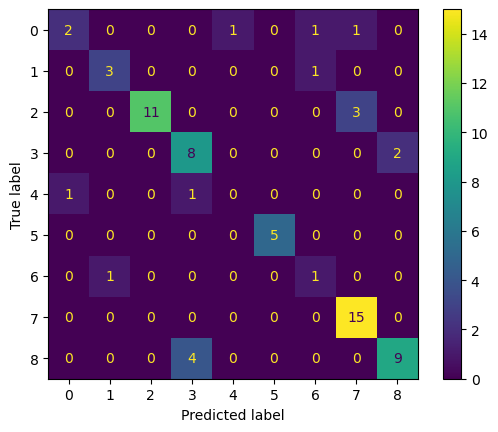

In [72]:
cm = confusion_matrix(label, vs_result)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [78]:
print(classification_report(label, vs_result, target_names=target_names))

                           precision    recall  f1-score   support

        mandibular canine       0.67      0.40      0.50         5
       mandibular incisor       0.75      0.75      0.75         4
         mandibular molar       1.00      0.79      0.88        14
      mandibular premolar       0.62      0.80      0.70        10
         maxillary canine       0.00      0.00      0.00         2
maxillary central incisor       1.00      1.00      1.00         5
maxillary lateral incisor       0.33      0.50      0.40         2
          maxillary molar       0.79      1.00      0.88        15
       maxillary premolar       0.82      0.69      0.75        13

                 accuracy                           0.77        70
                macro avg       0.66      0.66      0.65        70
             weighted avg       0.78      0.77      0.77        70



In [71]:
# Hard voting
f1_score(label, vh_result, average='micro')

0.8000000000000002

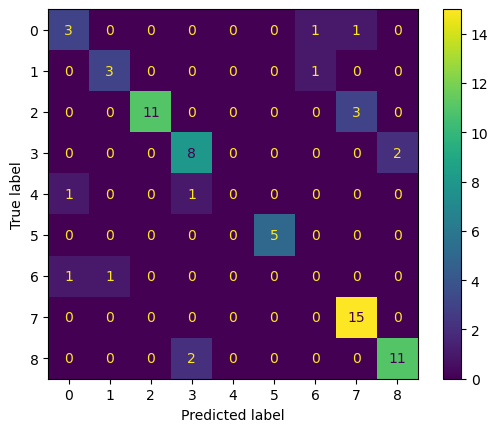

In [73]:
cm = confusion_matrix(label, vh_result)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# Hyperparameter Tuning

In [21]:
epochs = 30

lr_grid = [1e-3, 1e-4, 1e-5, 1e-6]
stem_stride_grid = [1, 2, 4, 6]
AlexNet3D_f1_values = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

for stem_stride in stem_stride_grid:
    for learning_rate in lr_grid:
        
        print('stem_stride:', stem_stride, ', learning_rate:',learning_rate)

        model = AlexNet3D(n_classes, stem_stride).to(device)

        criterion = nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), learning_rate)

        f1_record = 0

        for ep in range(epochs):

            start = time()
            loss, micro, macro = train3D(train_queue)
            epoch_time = time() - start
            print('\nEpoch: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Epoch time: %.4f s'
                  % (ep, loss, micro, macro, epoch_time))

            f1 = validation3D(valid_queue)

            if f1 > f1_record:
                f1_record = f1
                print("New record saved!")

        AlexNet3D_f1_values.append([learning_rate, stem_stride, f1_record])

Device: cuda
stem_stride: 1 , learning_rate: 0.001
Epoch: 0 Step: 43 Loss: 69.574478 Micro-F1: 0.318182 Macro-F1: 0.179618 Step time: 0.0358 ss
Epoch: 0 Loss: 69.574478 Micro-F1: 0.318182 Macro-F1: 0.179618 Epoch time: 90.2466 s
Validation step: 22 Loss: 2.046938 Micro-F1: 0.347826 Macro-F1: 0.172326 Step time: 1.2119 s
Validation loss: 2.046938 Micro-F1 0.347826 Macro-F1 0.051613 validation time: 27.8755 s
New record saved!
Epoch: 1 Step: 43 Loss: 1.918723 Micro-F1: 0.340909 Macro-F1: 0.211679 Step time: 0.0350 s
Epoch: 1 Loss: 1.918723 Micro-F1: 0.340909 Macro-F1: 0.211679 Epoch time: 88.4724 s
Validation step: 22 Loss: 1.823019 Micro-F1: 0.347826 Macro-F1: 0.172326 Step time: 1.2225 s
Validation loss: 1.823019 Micro-F1 0.347826 Macro-F1 0.051613 validation time: 28.1182 s
Epoch: 2 Step: 43 Loss: 1.830140 Micro-F1: 0.357955 Macro-F1: 0.176948 Step time: 0.0359 s
Epoch: 2 Loss: 1.830140 Micro-F1: 0.357955 Macro-F1: 0.176948 Epoch time: 88.8262 s
Validation step: 22 Loss: 1.856762 Micr

Epoch: 15 Step: 43 Loss: 0.734503 Micro-F1: 0.704545 Macro-F1: 0.614141 Step time: 0.0348 s
Epoch: 15 Loss: 0.734503 Micro-F1: 0.704545 Macro-F1: 0.614141 Epoch time: 87.0074 s
Validation step: 22 Loss: 0.860189 Micro-F1: 0.673913 Macro-F1: 0.525121 Step time: 1.2189 s
Validation loss: 0.860189 Micro-F1 0.673913 Macro-F1 0.363240 validation time: 28.0358 s
Epoch: 16 Step: 43 Loss: 0.892203 Micro-F1: 0.647727 Macro-F1: 0.531124 Step time: 0.0362 s
Epoch: 16 Loss: 0.892203 Micro-F1: 0.647727 Macro-F1: 0.531124 Epoch time: 87.1067 s
Validation step: 22 Loss: 0.809741 Micro-F1: 0.717391 Macro-F1: 0.598309 Step time: 1.2152 s
Validation loss: 0.809741 Micro-F1 0.717391 Macro-F1 0.398306 validation time: 27.9515 s
New record saved!
Epoch: 17 Step: 43 Loss: 0.781626 Micro-F1: 0.647727 Macro-F1: 0.511066 Step time: 0.0356 s
Epoch: 17 Loss: 0.781626 Micro-F1: 0.647727 Macro-F1: 0.511066 Epoch time: 87.1101 s
Validation step: 22 Loss: 1.020051 Micro-F1: 0.663043 Macro-F1: 0.560749 Step time: 1.2

Validation step: 22 Loss: 1.175341 Micro-F1: 0.554348 Macro-F1: 0.445169 Step time: 1.2092 s
Validation loss: 1.175341 Micro-F1 0.554348 Macro-F1 0.227668 validation time: 27.8126 s
New record saved!
Epoch: 8 Step: 43 Loss: 1.202644 Micro-F1: 0.494318 Macro-F1: 0.359470 Step time: 0.0373 s
Epoch: 8 Loss: 1.202644 Micro-F1: 0.494318 Macro-F1: 0.359470 Epoch time: 88.2256 s
Validation step: 22 Loss: 1.046201 Micro-F1: 0.630435 Macro-F1: 0.511473 Step time: 1.2053 s
Validation loss: 1.046201 Micro-F1 0.630435 Macro-F1 0.337182 validation time: 27.7239 s
New record saved!
Epoch: 9 Step: 43 Loss: 1.192227 Micro-F1: 0.511364 Macro-F1: 0.395644 Step time: 0.0357 s
Epoch: 9 Loss: 1.192227 Micro-F1: 0.511364 Macro-F1: 0.395644 Epoch time: 88.0686 s
Validation step: 22 Loss: 1.097194 Micro-F1: 0.630435 Macro-F1: 0.511473 Step time: 1.2109 s
Validation loss: 1.097194 Micro-F1 0.630435 Macro-F1 0.260649 validation time: 27.8514 s
Epoch: 10 Step: 43 Loss: 1.158382 Micro-F1: 0.500000 Macro-F1: 0.370

Epoch: 0 Step: 43 Loss: 2.281012 Micro-F1: 0.176136 Macro-F1: 0.114773 Step time: 0.0292 s
Epoch: 0 Loss: 2.281012 Micro-F1: 0.176136 Macro-F1: 0.114773 Epoch time: 88.9012 s
Validation step: 22 Loss: 2.244669 Micro-F1: 0.369565 Macro-F1: 0.209524 Step time: 1.3343 s
Validation loss: 2.244669 Micro-F1 0.369565 Macro-F1 0.072356 validation time: 30.6908 s
New record saved!
Epoch: 1 Step: 43 Loss: 2.141000 Micro-F1: 0.369318 Macro-F1: 0.208090 Step time: 0.0368 s
Epoch: 1 Loss: 2.141000 Micro-F1: 0.369318 Macro-F1: 0.208090 Epoch time: 89.2305 s
Validation step: 22 Loss: 1.954169 Micro-F1: 0.347826 Macro-F1: 0.172326 Step time: 1.2286 s
Validation loss: 1.954169 Micro-F1 0.347826 Macro-F1 0.051613 validation time: 28.2584 s
Epoch: 2 Step: 43 Loss: 1.814877 Micro-F1: 0.346591 Macro-F1: 0.197042 Step time: 0.0351 s
Epoch: 2 Loss: 1.814877 Micro-F1: 0.346591 Macro-F1: 0.197042 Epoch time: 88.8658 s
Validation step: 22 Loss: 1.750410 Micro-F1: 0.347826 Macro-F1: 0.172326 Step time: 1.2250 s


Validation step: 22 Loss: 1.158038 Micro-F1: 0.608696 Macro-F1: 0.498671 Step time: 1.2133 s
Validation loss: 1.158038 Micro-F1 0.608696 Macro-F1 0.270848 validation time: 27.9071 s
Epoch: 23 Step: 43 Loss: 1.196816 Micro-F1: 0.511364 Macro-F1: 0.401136 Step time: 0.0359 s
Epoch: 23 Loss: 1.196816 Micro-F1: 0.511364 Macro-F1: 0.401136 Epoch time: 88.4992 s
Validation step: 22 Loss: 1.101798 Micro-F1: 0.630435 Macro-F1: 0.527415 Step time: 1.2152 s
Validation loss: 1.101798 Micro-F1 0.630435 Macro-F1 0.284392 validation time: 27.9519 s
Epoch: 24 Step: 43 Loss: 1.226696 Micro-F1: 0.522727 Macro-F1: 0.407287 Step time: 0.0387 s
Epoch: 24 Loss: 1.226696 Micro-F1: 0.522727 Macro-F1: 0.407287 Epoch time: 88.5326 s
Validation step: 22 Loss: 1.058895 Micro-F1: 0.673913 Macro-F1: 0.555556 Step time: 1.2144 s
Validation loss: 1.058895 Micro-F1 0.673913 Macro-F1 0.371943 validation time: 27.9327 s
New record saved!
Epoch: 25 Step: 43 Loss: 1.211444 Micro-F1: 0.556818 Macro-F1: 0.418642 Step time:

Validation step: 22 Loss: 1.045098 Micro-F1: 0.576087 Macro-F1: 0.428623 Step time: 0.4697 s
Validation loss: 1.045098 Micro-F1 0.576087 Macro-F1 0.257409 validation time: 10.8032 s
Epoch: 8 Step: 43 Loss: 1.120248 Micro-F1: 0.494318 Macro-F1: 0.388654 Step time: 0.0021 s
Epoch: 8 Loss: 1.120248 Micro-F1: 0.494318 Macro-F1: 0.388654 Epoch time: 21.5196 s
Validation step: 22 Loss: 1.102709 Micro-F1: 0.532609 Macro-F1: 0.401812 Step time: 0.4662 s
Validation loss: 1.102709 Micro-F1 0.532609 Macro-F1 0.232583 validation time: 10.7244 s
Epoch: 9 Step: 43 Loss: 1.165989 Micro-F1: 0.545455 Macro-F1: 0.406178 Step time: 0.0021 s
Epoch: 9 Loss: 1.165989 Micro-F1: 0.545455 Macro-F1: 0.406178 Epoch time: 21.4163 s
Validation step: 22 Loss: 1.025150 Micro-F1: 0.532609 Macro-F1: 0.362957 Step time: 0.4595 s
Validation loss: 1.025150 Micro-F1 0.532609 Macro-F1 0.191084 validation time: 10.5710 s
Epoch: 10 Step: 43 Loss: 1.030695 Micro-F1: 0.562500 Macro-F1: 0.442487 Step time: 0.0021 s
Epoch: 10 Lo

Validation step: 22 Loss: 0.699425 Micro-F1: 0.782609 Macro-F1: 0.666304 Step time: 0.4744 s
Validation loss: 0.699425 Micro-F1 0.782609 Macro-F1 0.426622 validation time: 10.9125 s
Epoch: 23 Step: 43 Loss: 0.577929 Micro-F1: 0.767045 Macro-F1: 0.686679 Step time: 0.0021 s
Epoch: 23 Loss: 0.577929 Micro-F1: 0.767045 Macro-F1: 0.686679 Epoch time: 21.5886 s
Validation step: 22 Loss: 0.619727 Micro-F1: 0.782609 Macro-F1: 0.663406 Step time: 0.4715 s
Validation loss: 0.619727 Micro-F1 0.782609 Macro-F1 0.548624 validation time: 10.8462 s
Epoch: 24 Step: 43 Loss: 0.564905 Micro-F1: 0.755682 Macro-F1: 0.611319 Step time: 0.0021 s
Epoch: 24 Loss: 0.564905 Micro-F1: 0.755682 Macro-F1: 0.611319 Epoch time: 21.5593 s
Validation step: 22 Loss: 0.836305 Micro-F1: 0.760870 Macro-F1: 0.643478 Step time: 0.4651 s
Validation loss: 0.836305 Micro-F1 0.760870 Macro-F1 0.514845 validation time: 10.6991 s
Epoch: 25 Step: 43 Loss: 0.545523 Micro-F1: 0.772727 Macro-F1: 0.658478 Step time: 0.0021 s
Epoch: 2

Epoch: 15 Step: 43 Loss: 1.508122 Micro-F1: 0.443182 Macro-F1: 0.283865 Step time: 0.0021 s
Epoch: 15 Loss: 1.508122 Micro-F1: 0.443182 Macro-F1: 0.283865 Epoch time: 21.5814 s
Validation step: 22 Loss: 1.438865 Micro-F1: 0.543478 Macro-F1: 0.398792 Step time: 0.4704 s
Validation loss: 1.438865 Micro-F1 0.543478 Macro-F1 0.179798 validation time: 10.8207 s
Epoch: 16 Step: 43 Loss: 1.505271 Micro-F1: 0.409091 Macro-F1: 0.315972 Step time: 0.0021 s
Epoch: 16 Loss: 1.505271 Micro-F1: 0.409091 Macro-F1: 0.315972 Epoch time: 21.6180 s
Validation step: 22 Loss: 1.421985 Micro-F1: 0.565217 Macro-F1: 0.436749 Step time: 0.4696 s
Validation loss: 1.421985 Micro-F1 0.565217 Macro-F1 0.187179 validation time: 10.8031 s
Epoch: 17 Step: 43 Loss: 1.492737 Micro-F1: 0.454545 Macro-F1: 0.303193 Step time: 0.0021 s
Epoch: 17 Loss: 1.492737 Micro-F1: 0.454545 Macro-F1: 0.303193 Epoch time: 21.5859 s
Validation step: 22 Loss: 1.406581 Micro-F1: 0.565217 Macro-F1: 0.406159 Step time: 0.4678 s
Validation l

Validation step: 22 Loss: 1.811168 Micro-F1: 0.271739 Macro-F1: 0.146239 Step time: 0.4605 s
Validation loss: 1.811168 Micro-F1 0.271739 Macro-F1 0.042735 validation time: 10.5927 s
New record saved!
Epoch: 1 Step: 43 Loss: 1.738642 Micro-F1: 0.301136 Macro-F1: 0.173286 Step time: 0.0006 s
Epoch: 1 Loss: 1.738642 Micro-F1: 0.301136 Macro-F1: 0.173286 Epoch time: 18.5449 s
Validation step: 22 Loss: 1.644673 Micro-F1: 0.434783 Macro-F1: 0.282609 Step time: 0.4213 s
Validation loss: 1.644673 Micro-F1 0.434783 Macro-F1 0.106471 validation time: 9.6899 s
New record saved!
Epoch: 2 Step: 43 Loss: 1.548391 Micro-F1: 0.414773 Macro-F1: 0.254708 Step time: 0.0007 s
Epoch: 2 Loss: 1.548391 Micro-F1: 0.414773 Macro-F1: 0.254708 Epoch time: 17.9089 s
Validation step: 22 Loss: 1.678693 Micro-F1: 0.467391 Macro-F1: 0.316460 Step time: 0.4223 s
Validation loss: 1.678693 Micro-F1 0.467391 Macro-F1 0.119728 validation time: 9.7137 s
New record saved!
Epoch: 3 Step: 43 Loss: 1.508847 Micro-F1: 0.369318 

Validation step: 22 Loss: 1.036405 Micro-F1: 0.608696 Macro-F1: 0.478140 Step time: 0.4352 s
Validation loss: 1.036405 Micro-F1 0.608696 Macro-F1 0.318396 validation time: 10.0095 s
Epoch: 16 Step: 43 Loss: 0.901862 Micro-F1: 0.590909 Macro-F1: 0.463402 Step time: 0.0006 s
Epoch: 16 Loss: 0.901862 Micro-F1: 0.590909 Macro-F1: 0.463402 Epoch time: 17.9400 s
Validation step: 22 Loss: 0.849522 Micro-F1: 0.717391 Macro-F1: 0.570531 Step time: 0.4185 s
Validation loss: 0.849522 Micro-F1 0.717391 Macro-F1 0.323889 validation time: 9.6274 s
Epoch: 17 Step: 43 Loss: 0.863814 Micro-F1: 0.602273 Macro-F1: 0.459479 Step time: 0.0007 s
Epoch: 17 Loss: 0.863814 Micro-F1: 0.602273 Macro-F1: 0.459479 Epoch time: 18.1309 s
Validation step: 22 Loss: 0.868429 Micro-F1: 0.695652 Macro-F1: 0.560870 Step time: 0.4293 s
Validation loss: 0.868429 Micro-F1 0.695652 Macro-F1 0.371136 validation time: 9.8743 s
Epoch: 18 Step: 43 Loss: 0.788897 Micro-F1: 0.636364 Macro-F1: 0.499008 Step time: 0.0006 s
Epoch: 18 

Validation step: 22 Loss: 1.882541 Micro-F1: 0.347826 Macro-F1: 0.172326 Step time: 0.4156 s
Validation loss: 1.882541 Micro-F1 0.347826 Macro-F1 0.051613 validation time: 9.5591 s
New record saved!
Epoch: 1 Step: 43 Loss: 2.022328 Micro-F1: 0.340909 Macro-F1: 0.184560 Step time: 0.0006 s
Epoch: 1 Loss: 2.022328 Micro-F1: 0.340909 Macro-F1: 0.184560 Epoch time: 17.6134 s
Validation step: 22 Loss: 1.800565 Micro-F1: 0.271739 Macro-F1: 0.146239 Step time: 0.4126 s
Validation loss: 1.800565 Micro-F1 0.271739 Macro-F1 0.042735 validation time: 9.4909 s
Epoch: 2 Step: 43 Loss: 1.853325 Micro-F1: 0.289773 Macro-F1: 0.145915 Step time: 0.0005 s
Epoch: 2 Loss: 1.853325 Micro-F1: 0.289773 Macro-F1: 0.145915 Epoch time: 17.4612 s
Validation step: 22 Loss: 1.805331 Micro-F1: 0.347826 Macro-F1: 0.172326 Step time: 0.4091 s
Validation loss: 1.805331 Micro-F1 0.347826 Macro-F1 0.051613 validation time: 9.4101 s
Epoch: 3 Step: 43 Loss: 1.836245 Micro-F1: 0.352273 Macro-F1: 0.172980 Step time: 0.0005 

Validation step: 22 Loss: 1.791127 Micro-F1: 0.347826 Macro-F1: 0.172326 Step time: 0.4085 s
Validation loss: 1.791127 Micro-F1 0.347826 Macro-F1 0.051613 validation time: 9.3979 s
Epoch: 24 Step: 43 Loss: 1.801926 Micro-F1: 0.352273 Macro-F1: 0.176876 Step time: 0.0005 s
Epoch: 24 Loss: 1.801926 Micro-F1: 0.352273 Macro-F1: 0.176876 Epoch time: 17.4823 s
Validation step: 22 Loss: 1.797001 Micro-F1: 0.347826 Macro-F1: 0.172326 Step time: 0.4061 s
Validation loss: 1.797001 Micro-F1 0.347826 Macro-F1 0.051613 validation time: 9.3417 s
Epoch: 25 Step: 43 Loss: 1.819904 Micro-F1: 0.352273 Macro-F1: 0.181566 Step time: 0.0005 s
Epoch: 25 Loss: 1.819904 Micro-F1: 0.352273 Macro-F1: 0.181566 Epoch time: 17.7630 s
Validation step: 22 Loss: 1.794917 Micro-F1: 0.347826 Macro-F1: 0.172326 Step time: 0.4158 s
Validation loss: 1.794917 Micro-F1 0.347826 Macro-F1 0.051613 validation time: 9.5644 s
Epoch: 26 Step: 43 Loss: 1.810715 Micro-F1: 0.352273 Macro-F1: 0.179545 Step time: 0.0005 s
Epoch: 26 L

Validation step: 22 Loss: 1.134414 Micro-F1: 0.489130 Macro-F1: 0.328658 Step time: 0.4058 s
Validation loss: 1.134414 Micro-F1 0.489130 Macro-F1 0.141144 validation time: 9.3333 s
Epoch: 9 Step: 43 Loss: 1.208731 Micro-F1: 0.443182 Macro-F1: 0.338952 Step time: 0.0005 s
Epoch: 9 Loss: 1.208731 Micro-F1: 0.443182 Macro-F1: 0.338952 Epoch time: 17.4988 s
Validation step: 22 Loss: 1.113154 Micro-F1: 0.510870 Macro-F1: 0.357367 Step time: 0.4131 s
Validation loss: 1.113154 Micro-F1 0.510870 Macro-F1 0.174273 validation time: 9.5037 s
Epoch: 10 Step: 43 Loss: 1.168117 Micro-F1: 0.448864 Macro-F1: 0.339159 Step time: 0.0005 s
Epoch: 10 Loss: 1.168117 Micro-F1: 0.448864 Macro-F1: 0.339159 Epoch time: 17.6539 s
Validation step: 22 Loss: 1.100879 Micro-F1: 0.586957 Macro-F1: 0.437802 Step time: 0.4093 s
Validation loss: 1.100879 Micro-F1 0.586957 Macro-F1 0.200270 validation time: 9.4150 s
New record saved!
Epoch: 11 Step: 43 Loss: 1.148397 Micro-F1: 0.448864 Macro-F1: 0.312644 Step time: 0.00

Epoch: 1 Step: 43 Loss: 2.070493 Micro-F1: 0.346591 Macro-F1: 0.190711 Step time: 0.0005 s
Epoch: 1 Loss: 2.070493 Micro-F1: 0.346591 Macro-F1: 0.190711 Epoch time: 17.5211 s
Validation step: 22 Loss: 1.871248 Micro-F1: 0.347826 Macro-F1: 0.172326 Step time: 0.4149 s
Validation loss: 1.871248 Micro-F1 0.347826 Macro-F1 0.051613 validation time: 9.5446 s
Epoch: 2 Step: 43 Loss: 1.781025 Micro-F1: 0.329545 Macro-F1: 0.193642 Step time: 0.0006 s
Epoch: 2 Loss: 1.781025 Micro-F1: 0.329545 Macro-F1: 0.193642 Epoch time: 17.4285 s
Validation step: 22 Loss: 1.759101 Micro-F1: 0.271739 Macro-F1: 0.146239 Step time: 0.4212 s
Validation loss: 1.759101 Micro-F1 0.271739 Macro-F1 0.042735 validation time: 9.6893 s
Epoch: 3 Step: 43 Loss: 1.745524 Micro-F1: 0.329545 Macro-F1: 0.176299 Step time: 0.0005 s
Epoch: 3 Loss: 1.745524 Micro-F1: 0.329545 Macro-F1: 0.176299 Epoch time: 17.5870 s
Validation step: 22 Loss: 1.748334 Micro-F1: 0.347826 Macro-F1: 0.172326 Step time: 0.4074 s
Validation loss: 1.7

Epoch: 24 Step: 43 Loss: 1.521062 Micro-F1: 0.340909 Macro-F1: 0.209163 Step time: 0.0005 s
Epoch: 24 Loss: 1.521062 Micro-F1: 0.340909 Macro-F1: 0.209163 Epoch time: 17.5369 s
Validation step: 22 Loss: 1.480156 Micro-F1: 0.489130 Macro-F1: 0.340649 Step time: 0.4085 s
Validation loss: 1.480156 Micro-F1 0.489130 Macro-F1 0.125161 validation time: 9.3970 s
New record saved!
Epoch: 25 Step: 43 Loss: 1.508882 Micro-F1: 0.375000 Macro-F1: 0.257594 Step time: 0.0005 s
Epoch: 25 Loss: 1.508882 Micro-F1: 0.375000 Macro-F1: 0.257594 Epoch time: 17.7656 s
Validation step: 22 Loss: 1.457542 Micro-F1: 0.445652 Macro-F1: 0.299551 Step time: 0.4141 s
Validation loss: 1.457542 Micro-F1 0.445652 Macro-F1 0.111003 validation time: 9.5249 s
Epoch: 26 Step: 43 Loss: 1.484355 Micro-F1: 0.392045 Macro-F1: 0.285624 Step time: 0.0005 s
Epoch: 26 Loss: 1.484355 Micro-F1: 0.392045 Macro-F1: 0.285624 Epoch time: 17.4769 s
Validation step: 22 Loss: 1.435909 Micro-F1: 0.456522 Macro-F1: 0.310904 Step time: 0.407

In [22]:
AlexNet3D_f1_values

[[0.001, 1, 0.34782608695652173],
 [0.0001, 1, 0.8152173913043479],
 [1e-05, 1, 0.8478260869565218],
 [1e-06, 1, 0.7065217391304348],
 [0.001, 2, 0.34782608695652173],
 [0.0001, 2, 0.7608695652173914],
 [1e-05, 2, 0.8152173913043479],
 [1e-06, 2, 0.6195652173913043],
 [0.001, 4, 0.34782608695652173],
 [0.0001, 4, 0.782608695652174],
 [1e-05, 4, 0.8369565217391305],
 [1e-06, 4, 0.5869565217391305],
 [0.001, 6, 0.34782608695652173],
 [0.0001, 6, 0.7717391304347826],
 [1e-05, 6, 0.7934782608695652],
 [1e-06, 6, 0.5108695652173914]]

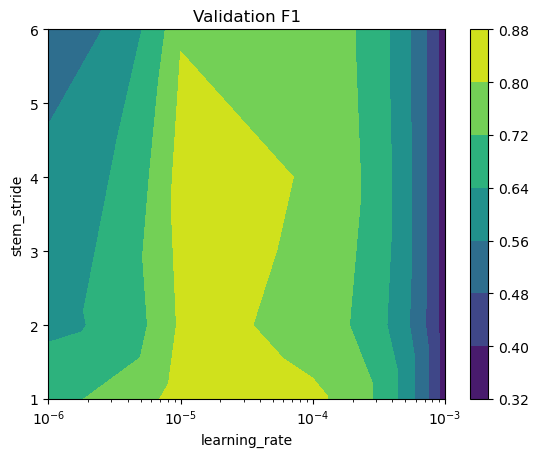

In [23]:
import matplotlib.pyplot as plt

result = torch.tensor(AlexNet3D_f1_values)
plt.tricontourf(result[:,0], result[:,1], result[:,2])
plt.xlabel("learning_rate")
plt.xscale('log')
plt.ylabel("stem_stride")
plt.title("Validation F1")
plt.colorbar()

In [22]:
epochs = 30

lr_grid = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
ResNet3D_f1_values = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

for learning_rate in lr_grid:

    print('learning_rate:',learning_rate)

    model = ResNet3D(n_classes).to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    f1_record = 0

    for ep in range(epochs):

        start = time()
        loss, micro, macro = train3D(train_queue)
        epoch_time = time() - start
        print('\nEpoch: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Epoch time: %.4f s'
              % (ep, loss, micro, macro, epoch_time))

        f1 = validation3D(valid_queue)

        if f1 > f1_record:
            f1_record = f1
            print("New record saved!")

    ResNet3D_f1_values.append([learning_rate, f1_record])

Device: cuda
learning_rate: 0.01


C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 Step: 43 Loss: 5.097858 Micro-F1: 0.232955 Macro-F1: 0.138654 Step time: 0.0225 s
Epoch: 0 Loss: 5.097858 Micro-F1: 0.232955 Macro-F1: 0.138654 Epoch time: 62.4333 s
Validation step: 22 Loss: 2.681596 Micro-F1: 0.358696 Macro-F1: 0.184248 Step time: 0.7683 s
Validation loss: 2.681596 Micro-F1 0.358696 Macro-F1 0.077089 validation time: 17.6719 s
New record saved!
Epoch: 1 Step: 43 Loss: 2.131958 Micro-F1: 0.261364 Macro-F1: 0.139033 Step time: 0.0231 s
Epoch: 1 Loss: 2.131958 Micro-F1: 0.261364 Macro-F1: 0.139033 Epoch time: 61.0653 s
Validation step: 22 Loss: 8.088040 Micro-F1: 0.032609 Macro-F1: 0.023913 Step time: 0.7837 s
Validation loss: 8.088040 Micro-F1 0.032609 Macro-F1 0.010828 validation time: 18.0275 s
Epoch: 2 Step: 43 Loss: 1.954418 Micro-F1: 0.318182 Macro-F1: 0.169535 Step time: 0.0220 s
Epoch: 2 Loss: 1.954418 Micro-F1: 0.318182 Macro-F1: 0.169535 Epoch time: 61.4480 s
Validation step: 22 Loss: 1.851415 Micro-F1: 0.271739 Macro-F1: 0.146239 Step time: 0.7761 s


C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 Step: 43 Loss: 2.366923 Micro-F1: 0.306818 Macro-F1: 0.195455 Step time: 0.0215 s
Epoch: 0 Loss: 2.366923 Micro-F1: 0.306818 Macro-F1: 0.195455 Epoch time: 62.1209 s
Validation step: 22 Loss: 1.914716 Micro-F1: 0.358696 Macro-F1: 0.232522 Step time: 0.7829 s
Validation loss: 1.914716 Micro-F1 0.358696 Macro-F1 0.087217 validation time: 18.0081 s
New record saved!
Epoch: 1 Step: 43 Loss: 1.979505 Micro-F1: 0.278409 Macro-F1: 0.171834 Step time: 0.0216 s
Epoch: 1 Loss: 1.979505 Micro-F1: 0.278409 Macro-F1: 0.171834 Epoch time: 62.0496 s
Validation step: 22 Loss: 1.981643 Micro-F1: 0.239130 Macro-F1: 0.132074 Step time: 0.7827 s
Validation loss: 1.981643 Micro-F1 0.239130 Macro-F1 0.039286 validation time: 18.0032 s
Epoch: 2 Step: 43 Loss: 1.995904 Micro-F1: 0.284091 Macro-F1: 0.159280 Step time: 0.0246 s
Epoch: 2 Loss: 1.995904 Micro-F1: 0.284091 Macro-F1: 0.159280 Epoch time: 62.0433 s
Validation step: 22 Loss: 1.861372 Micro-F1: 0.358696 Macro-F1: 0.201242 Step time: 0.7833 s


C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 Step: 43 Loss: 1.946703 Micro-F1: 0.329545 Macro-F1: 0.226578 Step time: 0.0244 s
Epoch: 0 Loss: 1.946703 Micro-F1: 0.329545 Macro-F1: 0.226578 Epoch time: 62.5686 s
Validation step: 22 Loss: 1.693450 Micro-F1: 0.500000 Macro-F1: 0.340097 Step time: 0.7842 s
Validation loss: 1.693450 Micro-F1 0.500000 Macro-F1 0.169830 validation time: 18.0372 s
New record saved!
Epoch: 1 Step: 43 Loss: 1.309301 Micro-F1: 0.517045 Macro-F1: 0.384470 Step time: 0.0239 s
Epoch: 1 Loss: 1.309301 Micro-F1: 0.517045 Macro-F1: 0.384470 Epoch time: 62.4117 s
Validation step: 22 Loss: 0.883914 Micro-F1: 0.717391 Macro-F1: 0.568720 Step time: 0.7825 s
Validation loss: 0.883914 Micro-F1 0.717391 Macro-F1 0.534566 validation time: 17.9989 s
New record saved!
Epoch: 2 Step: 43 Loss: 1.152461 Micro-F1: 0.551136 Macro-F1: 0.434425 Step time: 0.0238 s
Epoch: 2 Loss: 1.152461 Micro-F1: 0.551136 Macro-F1: 0.434425 Epoch time: 62.3897 s
Validation step: 22 Loss: 0.700200 Micro-F1: 0.826087 Macro-F1: 0.687440 St

C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 Step: 43 Loss: 2.114274 Micro-F1: 0.221591 Macro-F1: 0.134217 Step time: 0.0235 s
Epoch: 0 Loss: 2.114274 Micro-F1: 0.221591 Macro-F1: 0.134217 Epoch time: 62.4648 s
Validation step: 22 Loss: 1.800688 Micro-F1: 0.282609 Macro-F1: 0.169841 Step time: 0.7805 s
Validation loss: 1.800688 Micro-F1 0.282609 Macro-F1 0.073886 validation time: 17.9531 s
New record saved!
Epoch: 1 Step: 43 Loss: 1.611101 Micro-F1: 0.477273 Macro-F1: 0.346005 Step time: 0.0240 s
Epoch: 1 Loss: 1.611101 Micro-F1: 0.477273 Macro-F1: 0.346005 Epoch time: 62.3293 s
Validation step: 22 Loss: 1.584278 Micro-F1: 0.445652 Macro-F1: 0.307126 Step time: 0.7834 s
Validation loss: 1.584278 Micro-F1 0.445652 Macro-F1 0.156181 validation time: 18.0194 s
New record saved!
Epoch: 2 Step: 43 Loss: 1.387944 Micro-F1: 0.551136 Macro-F1: 0.435227 Step time: 0.0240 s
Epoch: 2 Loss: 1.387944 Micro-F1: 0.551136 Macro-F1: 0.435227 Epoch time: 62.4070 s
Validation step: 22 Loss: 1.357372 Micro-F1: 0.500000 Macro-F1: 0.337146 St

Validation step: 22 Loss: 0.548185 Micro-F1: 0.858696 Macro-F1: 0.744444 Step time: 0.7768 s
Validation loss: 0.548185 Micro-F1 0.858696 Macro-F1 0.658840 validation time: 17.8678 s
Epoch: 23 Step: 43 Loss: 0.440382 Micro-F1: 0.886364 Macro-F1: 0.838384 Step time: 0.0230 s
Epoch: 23 Loss: 0.440382 Micro-F1: 0.886364 Macro-F1: 0.838384 Epoch time: 62.3911 s
Validation step: 22 Loss: 0.705126 Micro-F1: 0.782609 Macro-F1: 0.644928 Step time: 0.7825 s
Validation loss: 0.705126 Micro-F1 0.782609 Macro-F1 0.563418 validation time: 17.9977 s
Epoch: 24 Step: 43 Loss: 0.533311 Micro-F1: 0.818182 Macro-F1: 0.729167 Step time: 0.0237 s
Epoch: 24 Loss: 0.533311 Micro-F1: 0.818182 Macro-F1: 0.729167 Epoch time: 62.4947 s
Validation step: 22 Loss: 0.514057 Micro-F1: 0.836957 Macro-F1: 0.720290 Step time: 0.7827 s
Validation loss: 0.514057 Micro-F1 0.836957 Macro-F1 0.619451 validation time: 18.0031 s
Epoch: 25 Step: 43 Loss: 0.535435 Micro-F1: 0.806818 Macro-F1: 0.741162 Step time: 0.0252 s
Epoch: 2

C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 Step: 43 Loss: 2.550816 Micro-F1: 0.068182 Macro-F1: 0.040088 Step time: 0.0247 s
Epoch: 0 Loss: 2.550816 Micro-F1: 0.068182 Macro-F1: 0.040088 Epoch time: 62.4278 s
Validation step: 22 Loss: 2.927250 Micro-F1: 0.097826 Macro-F1: 0.059420 Step time: 0.7843 s
Validation loss: 2.927250 Micro-F1 0.097826 Macro-F1 0.039708 validation time: 18.0394 s
New record saved!
Epoch: 1 Step: 43 Loss: 2.430322 Micro-F1: 0.085227 Macro-F1: 0.052841 Step time: 0.0228 s
Epoch: 1 Loss: 2.430322 Micro-F1: 0.085227 Macro-F1: 0.052841 Epoch time: 62.4065 s
Validation step: 22 Loss: 2.716153 Micro-F1: 0.108696 Macro-F1: 0.071377 Step time: 0.7817 s
Validation loss: 2.716153 Micro-F1 0.108696 Macro-F1 0.045149 validation time: 17.9791 s
New record saved!
Epoch: 2 Step: 43 Loss: 2.396612 Micro-F1: 0.056818 Macro-F1: 0.034659 Step time: 0.0234 s
Epoch: 2 Loss: 2.396612 Micro-F1: 0.056818 Macro-F1: 0.034659 Epoch time: 62.2949 s
Validation step: 22 Loss: 2.625373 Micro-F1: 0.097826 Macro-F1: 0.055435 St

In [23]:
ResNet3D_f1_values

[[0.01, 0.7065217391304348],
 [0.001, 0.6521739130434783],
 [0.0001, 0.9347826086956522],
 [1e-05, 0.8695652173913043],
 [1e-06, 0.6195652173913043]]

Text(0.5, 1.0, 'Validation F1')

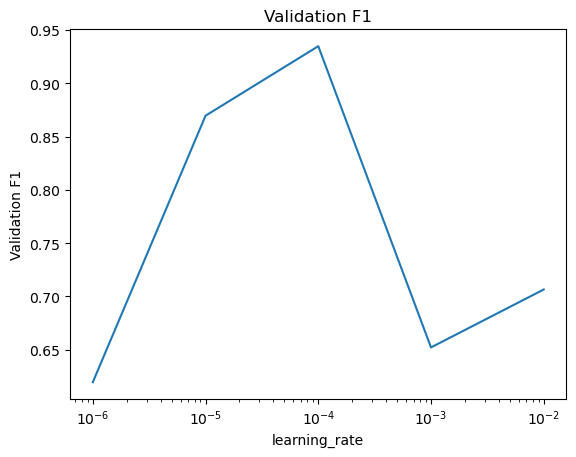

In [24]:
result = torch.tensor(ResNet3D_f1_values)
plt.plot(result[:,0], result[:,1])
plt.xlabel("learning_rate")
plt.xscale('log')
plt.ylabel("Validation F1")
plt.title("Validation F1")


# Final Model

In [23]:
all_train = pd.concat([X_train, X_valid]).reset_index(drop=True)
all_train

,Batch,Type,CT Scan,Tooth,Voxel,Label,Reject
0,Batch 2,22ND NOV 2022,2 Spine 1.0,Tooth_028.nrrd,5655,maxillary molar,NaN
1,FOURTH SCAN,LOWER CANINES 1255PM,3 Pediatric 0.5,Tooth_003.nrrd,17808,mandibular canine,NaN
2,SIXTH SCAN,U I 120 PM,3 Pediatric 0.5,Tooth_033.nrrd,20160,maxillary central incisor,NaN
3,SIXTH SCAN,U I 120 PM,3 Pediatric 0.5,Tooth_028.nrrd,24480,maxillary central incisor,NaN
4,FIRST SCAN,MOLARS 1142AM,3 Pediatric 0.5,Tooth_055.nrrd,42328,mandibular molar,NaN
...,...,...,...,...,...,...,...
263,FIRST SCAN,MOLARS 1142AM,3 Pediatric 0.5,Tooth_017.nrrd,45864,maxillary molar,NaN
264,FIRST SCAN,MOLARS 1142AM,3 Pediatric 0.5,Tooth_002.nrrd,56840,maxillary molar,NaN
265,NINTH SCAN,ENDO 2 135PM,3 Pediatric 0.5,Tooth_008.nrrd,35280,mandibular molar,NaN
266,SIXTH SCAN,U I 120 PM,3 Pediatric 0.5,Tooth_035.nrrd,13650,maxillary central incisor,NaN


In [24]:
all_train_set = TrainImageDataset(path, all_train, lab_dict, transform=augmentation, target_transform=None)
all_train_queue = DataLoader(all_train_set, batch_size=4, shuffle=True, num_workers=0)

# ResNet3D

In [33]:
# Final re-training
epochs = 23
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

model = ResNet3D(n_classes).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

f1_record = 0.9347826086956522

for ep in range(epochs):

    start = time()
    loss, micro, macro = train3D(all_train_queue)
    epoch_time = time() - start
    print('\nEpoch: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Epoch time: %.4f s'
          % (ep, loss, micro, macro, epoch_time))
    
    if micro > f1_record:
        ResNet3D_model_final = model
        torch.save(model.state_dict(), "ResNet3D-final.pth")
        print("Training finished!")
        break



Device: cuda


C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 Step: 66 Loss: 1.637160 Micro-F1: 0.444030 Macro-F1: 0.328459 Step time: 0.0132 s
Epoch: 0 Loss: 1.637160 Micro-F1: 0.444030 Macro-F1: 0.209946 Epoch time: 89.8214 s
Epoch: 1 Step: 66 Loss: 1.074856 Micro-F1: 0.600746 Macro-F1: 0.464925 Step time: 0.0144 s
Epoch: 1 Loss: 1.074856 Micro-F1: 0.600746 Macro-F1: 0.358786 Epoch time: 91.1867 s
Epoch: 2 Step: 66 Loss: 1.035272 Micro-F1: 0.611940 Macro-F1: 0.524864 Step time: 0.0133 s
Epoch: 2 Loss: 1.035272 Micro-F1: 0.611940 Macro-F1: 0.421998 Epoch time: 91.6914 s
Epoch: 3 Step: 66 Loss: 0.906510 Micro-F1: 0.656716 Macro-F1: 0.525344 Step time: 0.0119 s
Epoch: 3 Loss: 0.906510 Micro-F1: 0.656716 Macro-F1: 0.455013 Epoch time: 92.0682 s
Epoch: 4 Step: 66 Loss: 0.755313 Micro-F1: 0.705224 Macro-F1: 0.616335 Step time: 0.0130 s
Epoch: 4 Loss: 0.755313 Micro-F1: 0.705224 Macro-F1: 0.572906 Epoch time: 92.1167 s
Epoch: 5 Step: 66 Loss: 0.614961 Micro-F1: 0.824627 Macro-F1: 0.755804 Step time: 0.0133 s
Epoch: 5 Loss: 0.614961 Micro-F1: 

In [34]:
# Test
model = ResNet3D_model_final
model.eval()

y_collection = []
p_collection = []
with torch.no_grad(): 
    start = time()
    for step, (img, y) in enumerate(test_queue):
        if torch.cuda.is_available():
            # batch normalisation
            img = (img - torch.mean(img)) / torch.std(img)
            x_img = img[:, None, :, :, :].to('cuda')
            y = y.to('cuda')

        # calculate output
        p = model(x_img)
        y_true = torch.argmax(y, dim = 1).cpu()
        y_pred = torch.argmax(p, dim = 1).cpu()
        y_collection.append(y_true)
        p_collection.append(y_pred)
        
        if step % 1 == 0:
            step_time = (time() - start)/(step+1)
            print('\rStep: %d Step time: %.4f s' % (step, step_time), end='')

result = torch.cat(p_collection, dim=0)
label = torch.cat(y_collection, dim=0)

print('\nTotal test time: %.4f s' % (time() - start), end='')

Step: 22 Step time: 0.7391 s
Total test time: 17.0020 s

In [35]:
f1_score(label, result, average='micro')

0.7934782608695652

In [36]:
accuracy_score(label, result)

0.7934782608695652

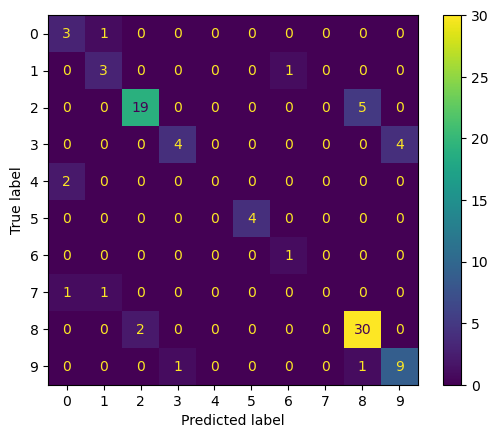

In [37]:
cm = confusion_matrix(label, result)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [38]:
lab_dict

{'mandibular canine': 0,
 'mandibular incisor': 1,
 'mandibular molar': 2,
 'mandibular premolar': 3,
 'maxillary canine': 4,
 'maxillary central incisor': 5,
 'maxillary incisor': 6,
 'maxillary lateral incisor': 7,
 'maxillary molar': 8,
 'maxillary premolar': 9}

In [39]:
print(classification_report(label, result, target_names=target_names))

                           precision    recall  f1-score   support

        mandibular canine       0.50      0.75      0.60         4
       mandibular incisor       0.60      0.75      0.67         4
         mandibular molar       0.90      0.79      0.84        24
      mandibular premolar       0.80      0.50      0.62         8
         maxillary canine       0.00      0.00      0.00         2
maxillary central incisor       1.00      1.00      1.00         4
        maxillary incisor       0.50      1.00      0.67         1
maxillary lateral incisor       0.00      0.00      0.00         2
          maxillary molar       0.83      0.94      0.88        32
       maxillary premolar       0.69      0.82      0.75        11

                 accuracy                           0.79        92
                macro avg       0.58      0.65      0.60        92
             weighted avg       0.77      0.79      0.78        92



C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
all_train['Label'].value_counts()

Label
maxillary molar              94
mandibular molar             72
maxillary premolar           34
mandibular premolar          22
maxillary central incisor    12
mandibular canine            11
mandibular incisor            9
maxillary canine              5
maxillary lateral incisor     5
maxillary incisor             4
Name: count, dtype: int64

# AlexNet3D

In [25]:
# Final re-training
epochs = 30
learning_rate = 1e-5
stem_stride = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

model = AlexNet3D(n_classes, stem_stride).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

f1_record = 0.8478260869565218

for ep in range(epochs):

    start = time()
    loss, micro, macro = train3D(all_train_queue)
    epoch_time = time() - start
    print('\nEpoch: %d Loss: %.6f Micro-F1: %.6f Macro-F1: %.6f Epoch time: %.4f s'
          % (ep, loss, micro, macro, epoch_time))
    
    if micro > f1_record:
        AlexNet3D_model_final = model
        torch.save(model.state_dict(), "AlexNet3D-final.pth")
        print("Training finished!")
        break



Device: cuda
Epoch: 0 Step: 66 Loss: 1.832620 Micro-F1: 0.376866 Macro-F1: 0.230994 Step time: 0.0251 s
Epoch: 0 Loss: 1.832620 Micro-F1: 0.376866 Macro-F1: 0.088235 Epoch time: 138.8781 s
Epoch: 1 Step: 66 Loss: 1.577292 Micro-F1: 0.380597 Macro-F1: 0.268076 Step time: 0.0246 s
Epoch: 1 Loss: 1.577292 Micro-F1: 0.380597 Macro-F1: 0.113554 Epoch time: 135.6439 s
Epoch: 2 Step: 66 Loss: 1.455361 Micro-F1: 0.455224 Macro-F1: 0.335015 Step time: 0.0240 s
Epoch: 2 Loss: 1.455361 Micro-F1: 0.455224 Macro-F1: 0.184321 Epoch time: 136.0397 s
Epoch: 3 Step: 66 Loss: 1.349178 Micro-F1: 0.511194 Macro-F1: 0.378666 Step time: 0.0225 s
Epoch: 3 Loss: 1.349178 Micro-F1: 0.511194 Macro-F1: 0.209049 Epoch time: 136.4340 s
Epoch: 4 Step: 66 Loss: 1.258158 Micro-F1: 0.511194 Macro-F1: 0.387627 Step time: 0.0237 s
Epoch: 4 Loss: 1.258158 Micro-F1: 0.511194 Macro-F1: 0.196096 Epoch time: 136.4713 s
Epoch: 5 Step: 66 Loss: 1.246733 Micro-F1: 0.526119 Macro-F1: 0.407131 Step time: 0.0216 s
Epoch: 5 Loss: 1

In [26]:
# Test
model = AlexNet3D_model_final
model.eval()

y_collection = []
p_collection = []
with torch.no_grad(): 
    start = time()
    for step, (img, y) in enumerate(test_queue):
        if torch.cuda.is_available():
            # batch normalisation
            img = (img - torch.mean(img)) / torch.std(img)
            x_img = img[:, None, :, :, :].to('cuda')
            y = y.to('cuda')

        # calculate output
        p = model(x_img)
        y_true = torch.argmax(y, dim = 1).cpu()
        y_pred = torch.argmax(p, dim = 1).cpu()
        y_collection.append(y_true)
        p_collection.append(y_pred)
        
        if step % 1 == 0:
            step_time = (time() - start)/(step+1)
            print('\rStep: %d Step time: %.4f s' % (step, step_time), end='')

result = torch.cat(p_collection, dim=0)
label = torch.cat(y_collection, dim=0)

print('\nTotal test time: %.4f s' % (time() - start), end='')

Step: 22 Step time: 1.1356 s
Total test time: 26.1207 s

In [27]:
f1_score(label, result, average='micro')

0.6956521739130435

In [28]:
accuracy_score(label, result)

0.6956521739130435

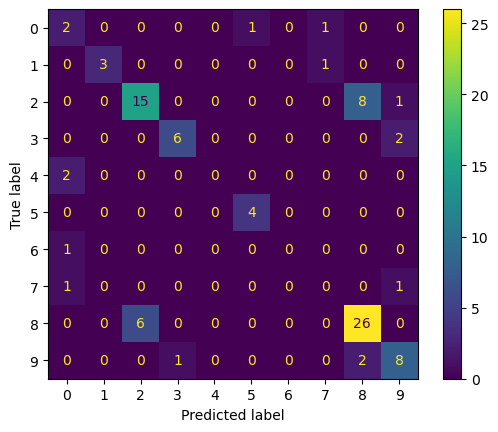

In [29]:
cm = confusion_matrix(label, result)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [30]:
lab_dict

{'mandibular canine': 0,
 'mandibular incisor': 1,
 'mandibular molar': 2,
 'mandibular premolar': 3,
 'maxillary canine': 4,
 'maxillary central incisor': 5,
 'maxillary incisor': 6,
 'maxillary lateral incisor': 7,
 'maxillary molar': 8,
 'maxillary premolar': 9}

In [31]:
print(classification_report(label, result, target_names=target_names))

                           precision    recall  f1-score   support

        mandibular canine       0.33      0.50      0.40         4
       mandibular incisor       1.00      0.75      0.86         4
         mandibular molar       0.71      0.62      0.67        24
      mandibular premolar       0.86      0.75      0.80         8
         maxillary canine       0.00      0.00      0.00         2
maxillary central incisor       0.80      1.00      0.89         4
        maxillary incisor       0.00      0.00      0.00         1
maxillary lateral incisor       0.00      0.00      0.00         2
          maxillary molar       0.72      0.81      0.76        32
       maxillary premolar       0.67      0.73      0.70        11

                 accuracy                           0.70        92
                macro avg       0.51      0.52      0.51        92
             weighted avg       0.68      0.70      0.69        92



C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phykawing\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
all_train['Label'].value_counts()

Label
maxillary molar              94
mandibular molar             72
maxillary premolar           34
mandibular premolar          22
maxillary central incisor    12
mandibular canine            11
mandibular incisor            9
maxillary canine              5
maxillary lateral incisor     5
maxillary incisor             4
Name: count, dtype: int64